# **Multi-Ticker Volatility Prediction**

### **Problem Statement:** 

Financial markets are highly influenced by both quantitative factors (historical prices, technical indicators) and qualitative factors (news, sentiment, market events). Traditional forecasting models often rely solely on price time series, ignoring the impact of external information, while sentiment analysis models typically lack integration with quantitative trading signals.

### **Objective:**

The objective of this project is to develop a Multimodal Deep Learning system to build a unified predictive framework that leverages both structured numerical data and unstructured textual data to improve financial forecasting accuracy and trading decision-making and compare the efficiency with advanced ML models and Traditional DL models.

### **Dataset:**

This Project uses two different datasets, one was extracted from the *yfinance* library and the other one was taken from *Kaggle*, which were later merged using common *Date* column.
* **Dataset 1:** contains information about historical stock market data (prices, volumes, financial statements etc.) from *Yahoo Finance*.
* **Dataset 2:** contains historical news headlines from *Reddit WorldNews Channel (/r/worldnews)*.

The merged dataset with *~48k datapoints* and *30 features* covers daily stock prices and relevant price data along with the sentiment of top 25 news headlines over nearly 8 years.

## *Importing Libraries*

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.layers import Layer
import joblib

2025-09-21 10:15:26.271435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758449726.648678      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758449726.754716      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
%%capture
!pip install keybert tqdm

In [5]:
from keybert import KeyBERT
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

## *Dataset Generation, Upload and Preview*

In [46]:
tickers = [
    "AAPL","MSFT","INTC","CSCO","ORCL","IBM","HPQ","DELL",
    "JPM","BAC","C","WFC","GS","MS","AXP","V","USB",
    "WMT","PG","KO","PEP","JNJ","MCD","HD","CAT"
]

start_date = "2008-01-01"
end_date = "2016-12-31"

In [50]:
def add_stock_features(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Close'] = df['Close'].astype(float)
    df['Daily_Return'] = df['Close'].pct_change()
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Volatility'] = df['Log_Return'].rolling(window=20).std() * np.sqrt(252)
    df["Target_Label"] = df["Log_Return"].shift(-1).apply(lambda x: 1 if x > 0.001 else (-1 if x < -0.001 else 0))
    df['Target_Volatility'] = df['Volatility'].shift(-1)

    for lag in range(1, 4):
        df[f'Close_Lag{lag}'] = df['Close'].shift(lag)
        df[f'Log_Return_Lag{lag}'] = df['Log_Return'].shift(lag)

    for lag in [3, 5, 10]:
        df[f'Volatility_Lag{lag}'] = df['Volatility'].shift(lag)

    df['SMA_5']  = df['Close'].rolling(5).mean()
    df['SMA_10'] = df['Close'].rolling(10).mean()
    df['SMA_ratio'] = df['SMA_5'] / df['SMA_10']

    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = rolling_mean + (rolling_std * 2)
    df['Bollinger_Lower'] = rolling_mean - (rolling_std * 2)
    df["Bollinger_Width"] = df["Bollinger_Upper"] - df["Bollinger_Lower"]

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    roll_up = up.ewm(span=14).mean()
    roll_down = down.ewm(span=14).mean()
    RS = roll_up / roll_down
    df['RSI_14'] = 100 - (100 / (1 + RS))

    df = df.dropna()

    return df

In [51]:
all_data = []

for ticker in tickers:
    print(f"Downloading {ticker}...")
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = [col[0] for col in stock_data.columns]

    stock_data.reset_index(inplace=True)
    stock_data = add_stock_features(stock_data)
    stock_data['Ticker'] = ticker
    all_data.append(stock_data)

combined_data = pd.concat(all_data, axis=0, ignore_index=True)

combined_data.to_csv("combined_stock_data.csv", index=False)

print("Download complete! Data saved to combined_stock_data.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


Download complete! Data saved to combined_stock_data.csv


In [52]:
stock = pd.read_csv("combined_stock_data.csv")

In [ ]:
stock.sample(5)

In [53]:
stock.shape

(53675, 28)

In [54]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53675 entries, 0 to 53674
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               53675 non-null  object 
 1   Close              53675 non-null  float64
 2   High               53675 non-null  float64
 3   Low                53675 non-null  float64
 4   Open               53675 non-null  float64
 5   Volume             53675 non-null  int64  
 6   Daily_Return       53675 non-null  float64
 7   Log_Return         53675 non-null  float64
 8   Volatility         53675 non-null  float64
 9   Target_Label       53675 non-null  int64  
 10  Target_Volatility  53675 non-null  float64
 11  Close_Lag1         53675 non-null  float64
 12  Log_Return_Lag1    53675 non-null  float64
 13  Close_Lag2         53675 non-null  float64
 14  Log_Return_Lag2    53675 non-null  float64
 15  Close_Lag3         53675 non-null  float64
 16  Log_Return_Lag3    536

In [55]:
news = pd.read_csv("/kaggle/input/stocknews/Combined_News_DJIA.csv")

In [ ]:
news.sample(5)

In [56]:
news.shape

(1989, 27)

In [57]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1989 non-null   object
 1   Label   1989 non-null   int64 
 2   Top1    1989 non-null   object
 3   Top2    1989 non-null   object
 4   Top3    1989 non-null   object
 5   Top4    1989 non-null   object
 6   Top5    1989 non-null   object
 7   Top6    1989 non-null   object
 8   Top7    1989 non-null   object
 9   Top8    1989 non-null   object
 10  Top9    1989 non-null   object
 11  Top10   1989 non-null   object
 12  Top11   1989 non-null   object
 13  Top12   1989 non-null   object
 14  Top13   1989 non-null   object
 15  Top14   1989 non-null   object
 16  Top15   1989 non-null   object
 17  Top16   1989 non-null   object
 18  Top17   1989 non-null   object
 19  Top18   1989 non-null   object
 20  Top19   1989 non-null   object
 21  Top20   1989 non-null   object
 22  Top21   1989 non-null   

In [58]:
news.drop('Label', axis = 1, inplace = True)

In [59]:
stock['Date'] = pd.to_datetime(stock['Date'])
news['Date'] = pd.to_datetime(news['Date'])

In [60]:
df = pd.merge(stock, news, on='Date', how='inner')

In [61]:
df.shape

(47736, 53)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47736 entries, 0 to 47735
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               47736 non-null  datetime64[ns]
 1   Close              47736 non-null  float64       
 2   High               47736 non-null  float64       
 3   Low                47736 non-null  float64       
 4   Open               47736 non-null  float64       
 5   Volume             47736 non-null  int64         
 6   Daily_Return       47736 non-null  float64       
 7   Log_Return         47736 non-null  float64       
 8   Volatility         47736 non-null  float64       
 9   Target_Label       47736 non-null  int64         
 10  Target_Volatility  47736 non-null  float64       
 11  Close_Lag1         47736 non-null  float64       
 12  Log_Return_Lag1    47736 non-null  float64       
 13  Close_Lag2         47736 non-null  float64       
 14  Log_Re

## *News Sentiment Extraction*

In [63]:
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

In [64]:
for i in range(1, 26):
    df[f"Top{i}"] = df[f"Top{i}"].astype(str).apply(clean_text)

df["All_News"] = df[[f"Top{i}" for i in range(1, 26)]].apply(lambda x: list(set(x.dropna())), axis=1)


In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone").to(device)
model.eval()

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [66]:
def get_finbert_sentiment(texts, batch_size=32):
    """Run FinBERT sentiment analysis in batches without printing per row."""
    all_scores = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True,
                           return_tensors="pt", max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
        all_scores.append(scores.cpu().numpy())
    return np.vstack(all_scores)

In [67]:
def aggregate_sentiment(news_list):
    """Aggregate FinBERT scores for a list of headlines (no print)."""
    if not news_list:
        return 0
    scores = get_finbert_sentiment(news_list)
    avg_sentiment = np.mean(scores[:, 2] - scores[:, 0])
    return avg_sentiment

In [68]:
tqdm.pandas()
df["FinBERT_Sentiment"] = df["All_News"].progress_apply(aggregate_sentiment)

100%|██████████| 47736/47736 [1:14:26<00:00, 10.69it/s]


In [69]:
def weighted_sentiment(news_list):
    if not news_list:
        return 0
    scores = get_finbert_sentiment(news_list)
    weights = np.exp(-np.arange(len(news_list))[::-1])
    return np.average(scores[:,2] - scores[:,0], weights=weights)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [71]:
tqdm.pandas()
df["Weighted_FinBERT"] = df["All_News"].progress_apply(weighted_sentiment)

100%|██████████| 47736/47736 [1:14:23<00:00, 10.69it/s]


In [72]:
kw_model = KeyBERT()
tqdm.pandas()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [73]:
topic_cache = {}

def extract_topics(text):
    if not text:
        return []
    if text in topic_cache:
        return topic_cache[text]
    keywords = kw_model.extract_keywords(text, top_n=3)
    topics = [kw for kw, score in keywords]
    topic_cache[text] = topics
    return topics

In [74]:
df["KeyBERT_Topics"] = df["All_News"].progress_apply(
    lambda x: extract_topics(" ".join(x)) if x else []
)

100%|██████████| 47736/47736 [02:13<00:00, 357.01it/s]  


In [75]:
df['KeyBERT_Topics']

0                 [sanctions, iran, israel]
1             [georgian, russians, georgia]
2        [georgia, georgiarussia, georgian]
3           [tbilisi, bgorbachev, georgian]
4             [caucasus, georgian, russias]
                        ...                
47731               [brexit, sterling, uks]
47732          [brexit, gibraltar, britons]
47733           [brexiteer, brexit, corbyn]
47734         [istanbuls, istanbul, turkey]
47735        [offenders, martyr, militancy]
Name: KeyBERT_Topics, Length: 47736, dtype: object

In [76]:
df["Topics_Text"] = df["KeyBERT_Topics"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

In [77]:
vectorizer = TfidfVectorizer(max_features=100)  # limit to 100 features to avoid high dimensionality
tfidf_matrix = vectorizer.fit_transform(df["Topics_Text"])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"Topic_TFIDF_{i}" for i in range(tfidf_matrix.shape[1])])

tfidf_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

df = pd.concat([df, tfidf_df], axis=1)

print("Final dataset shape:", df.shape)
print("TF-IDF features added:", tfidf_df.shape[1])

Final dataset shape: (47736, 158)
TF-IDF features added: 100


## *Data Preprocessing and Feature Extraction*

In [78]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["DayOfWeek"] = df["Date"].dt.dayofweek

In [79]:
df = df.sort_values("Date")
df = df.set_index("Date")

In [80]:
obj_cols = [f"Top{i}" for i in range(1, 26)] + ["All_News", "KeyBERT_Topics", "Topics_Text"]
df_final = df.drop(columns=obj_cols)

In [81]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47736 entries, 2008-08-08 to 2016-07-01
Columns: 132 entries, Close to DayOfWeek
dtypes: float32(1), float64(125), int32(3), int64(2), object(1)
memory usage: 47.7+ MB


In [82]:
tfidf_cols = [col for col in df_final.columns if col.startswith("Topic_TFIDF_")]

scaler = StandardScaler()
tfidf_scaled = scaler.fit_transform(df_final[tfidf_cols])

pca = PCA(n_components=10, random_state=42)
tfidf_pca = pca.fit_transform(tfidf_scaled)

for i in range(tfidf_pca.shape[1]):
    df_final[f'TFIDF_PCA_{i}'] = tfidf_pca[:, i]

In [83]:
df_final = df_final.drop(columns=tfidf_cols)

In [84]:
df_final.to_csv('final_stock_with_news.csv')

In [3]:
df_final = pd.read_csv("/kaggle/input/final-data/final_stock_with_news.csv")

In [4]:
df_final.sample(5)

Date      Close       High        Low       Open     Volume  \
26850  2013-01-17  28.831736  28.989971  28.815079  28.948328   17827100   
4372   2009-04-30  14.439817  15.115573  14.208638  14.257541  101753600   
24928  2012-09-20  19.171774  19.189727  19.061487  19.061487   13569600   
16592  2011-05-06  96.037720  96.754208  95.668104  96.117334    5062012   
3906   2009-04-01  18.885897  19.231172  17.876130  17.915218   15308300   

       Daily_Return  Log_Return  Volatility  Target_Label  ...  TFIDF_PCA_0  \
26850     -0.000577   -0.000578    0.217558             1  ...    -0.108546   
4372       0.022831    0.022574    0.562394             0  ...    -0.108546   
24928      0.005109    0.005096    0.125822            -1  ...    -0.242572   
16592      0.007036    0.007011    0.126988             1  ...    -0.184196   
3906       0.036838    0.036176    0.781422             1  ...     3.710826   

       TFIDF_PCA_1  TFIDF_PCA_2  TFIDF_PCA_3  TFIDF_PCA_4  TFIDF_PCA_5  \
26850    -0.112271     0.013839    -0.069068     0.037780     0.051657   
4372     -0.112271     0.013839    -0.069068     0.037780     0.051657   
24928     0.778473    -0.475062    -2.463915     5.711706    -2.860200   
16592    -0.765054    -0.074506    -0.818160    -0.371825     0.413491   
3906      1.525755     0.822233     0.260878    -0.723773    -0.489365   

       TFIDF_PCA_6  TFIDF_PCA_7  TFIDF_PCA_8  TFIDF_PCA_9  
26850     0.025493    -0.012854    -0.018736     0.046106  
4372      0.025493    -0.012854    -0.018736     0.046106  
24928    -2.539916     1.836043     1.104001     0.462703  
16592     0.808333    -1.256348     0.102377    -0.225951  
3906     -1.277477    -0.348865    -2.039000    -0.396977  

[5 rows x 43 columns]

In [5]:
df_final.shape

(47736, 43)

In [6]:
df_final = df_final.sort_values(by = ["Date", "Ticker"])
df_final = df_final.set_index("Date")

In [7]:
sentiment_cols = ['FinBERT_Sentiment', 'Weighted_FinBERT']

for col in sentiment_cols:
    for lag in range(1, 4):
        df_final[f'{col}_Lag{lag}'] = (
            df_final.groupby("Ticker")[col]
            .shift(lag)
        )
        df_final[f'{col}_Lag{lag}'] = df_final.groupby("Ticker")[f'{col}_Lag{lag}'] \
                                              .transform(lambda s: s.fillna(method='bfill').fillna(method='ffill'))

for col in sentiment_cols:
    df_final[f'{col}_Roll5'] = (
        df_final.groupby("Ticker")[col]
        .transform(lambda s: s.rolling(5, min_periods=1).mean())
    )
    df_final[f'{col}_Roll10'] = (
        df_final.groupby("Ticker")[col]
        .transform(lambda s: s.rolling(10, min_periods=1).mean())
    )

## *EDA and Data Visualization*

In [88]:
df_final.describe().T

count          mean           std            min  \
Close                     47736.0  3.803140e+01  2.925972e+01       2.347573   
High                      47736.0  3.839647e+01  2.949535e+01       2.461650   
Low                       47736.0  3.765026e+01  2.902002e+01       1.962912   
Open                      47736.0  3.802732e+01  2.925695e+01       2.383297   
Volume                    47736.0  4.660998e+07  1.157100e+08  694200.000000   
Daily_Return              47736.0  5.126402e-04  2.356798e-02      -0.390244   
Log_Return                47736.0  2.390123e-04  2.335636e-02      -0.494696   
Volatility                47736.0  2.790933e-01  2.490640e-01       0.044429   
Target_Label              47736.0  3.033350e-02  9.631100e-01      -1.000000   
Target_Volatility         47736.0  2.789703e-01  2.489119e-01       0.044429   
Close_Lag1                47736.0  3.802293e+01  2.925853e+01       2.347573   
Log_Return_Lag1           47736.0  2.286762e-04  2.336734e-02      -0.494696   
Close_Lag2                47736.0  3.801499e+01  2.925838e+01       2.347573   
Log_Return_Lag2           47736.0  2.233931e-04  2.336781e-02      -0.494696   
Close_Lag3                47736.0  3.800737e+01  2.925877e+01       2.347573   
Log_Return_Lag3           47736.0  2.290843e-04  2.337471e-02      -0.494696   
Volatility_Lag3           47736.0  2.794547e-01  2.495122e-01       0.044429   
Volatility_Lag5           47736.0  2.797235e-01  2.498298e-01       0.044429   
Volatility_Lag10          47736.0  2.805796e-01  2.505685e-01       0.044429   
SMA_5                     47736.0  3.801527e+01  2.924879e+01       2.474078   
SMA_10                    47736.0  3.799556e+01  2.923959e+01       2.566120   
SMA_ratio                 47736.0  1.000584e+00  1.959790e-02       0.665874   
Bollinger_Upper           47736.0  3.984606e+01  3.054108e+01       2.838172   
Bollinger_Lower           47736.0  3.606086e+01  2.802679e+01       1.648402   
Bollinger_Width           47736.0  3.785199e+00  4.569693e+00       0.266451   
RSI_14                    47736.0  5.279921e+01  1.593797e+01       4.734687   
FinBERT_Sentiment         47736.0 -5.239790e-01  1.591971e-01      -0.911573   
Weighted_FinBERT          47736.0 -5.283251e-01  5.128832e-01      -0.999816   
Year                      47736.0  2.012050e+03  2.317572e+00    2008.000000   
Month                     47736.0  6.544495e+00  3.446773e+00       1.000000   
DayOfWeek                 47736.0  2.017094e+00  1.399472e+00       0.000000   
TFIDF_PCA_0               47736.0 -3.810519e-17  1.385022e+00      -4.215938   
TFIDF_PCA_1               47736.0  3.810519e-17  1.315895e+00      -3.817370   
TFIDF_PCA_2               47736.0  2.000523e-16  1.281133e+00      -2.609135   
TFIDF_PCA_3               47736.0  7.621038e-17  1.246241e+00      -3.343282   
TFIDF_PCA_4               47736.0  3.810519e-17  1.239854e+00      -3.655239   
TFIDF_PCA_5               47736.0 -1.905260e-17  1.218108e+00      -3.548941   
TFIDF_PCA_6               47736.0 -2.381574e-16  1.211365e+00      -6.157098   
TFIDF_PCA_7               47736.0 -5.001306e-17  1.184142e+00      -5.794633   
TFIDF_PCA_8               47736.0  3.858151e-16  1.180511e+00      -4.522666   
TFIDF_PCA_9               47736.0 -9.526298e-18  1.155533e+00      -3.513048   
FinBERT_Sentiment_Lag1    47736.0 -5.239401e-01  1.592075e-01      -0.911573   
FinBERT_Sentiment_Lag2    47736.0 -5.239126e-01  1.592168e-01      -0.911573   
FinBERT_Sentiment_Lag3    47736.0 -5.238939e-01  1.592241e-01      -0.911573   
Weighted_FinBERT_Lag1     47736.0 -5.282745e-01  5.128507e-01      -0.999816   
Weighted_FinBERT_Lag2     47736.0 -5.282599e-01  5.128423e-01      -0.999816   
Weighted_FinBERT_Lag3     47736.0 -5.287242e-01  5.126770e-01      -0.999816   
FinBERT_Sentiment_Roll5   47736.0 -5.239294e-01  8.383714e-02      -0.777790   
FinBERT_Sentiment_Roll10  47736.0 -5.239496e-01  6.753702e-02      -0.741409   
Weighted_FinBERT_Roll5    47

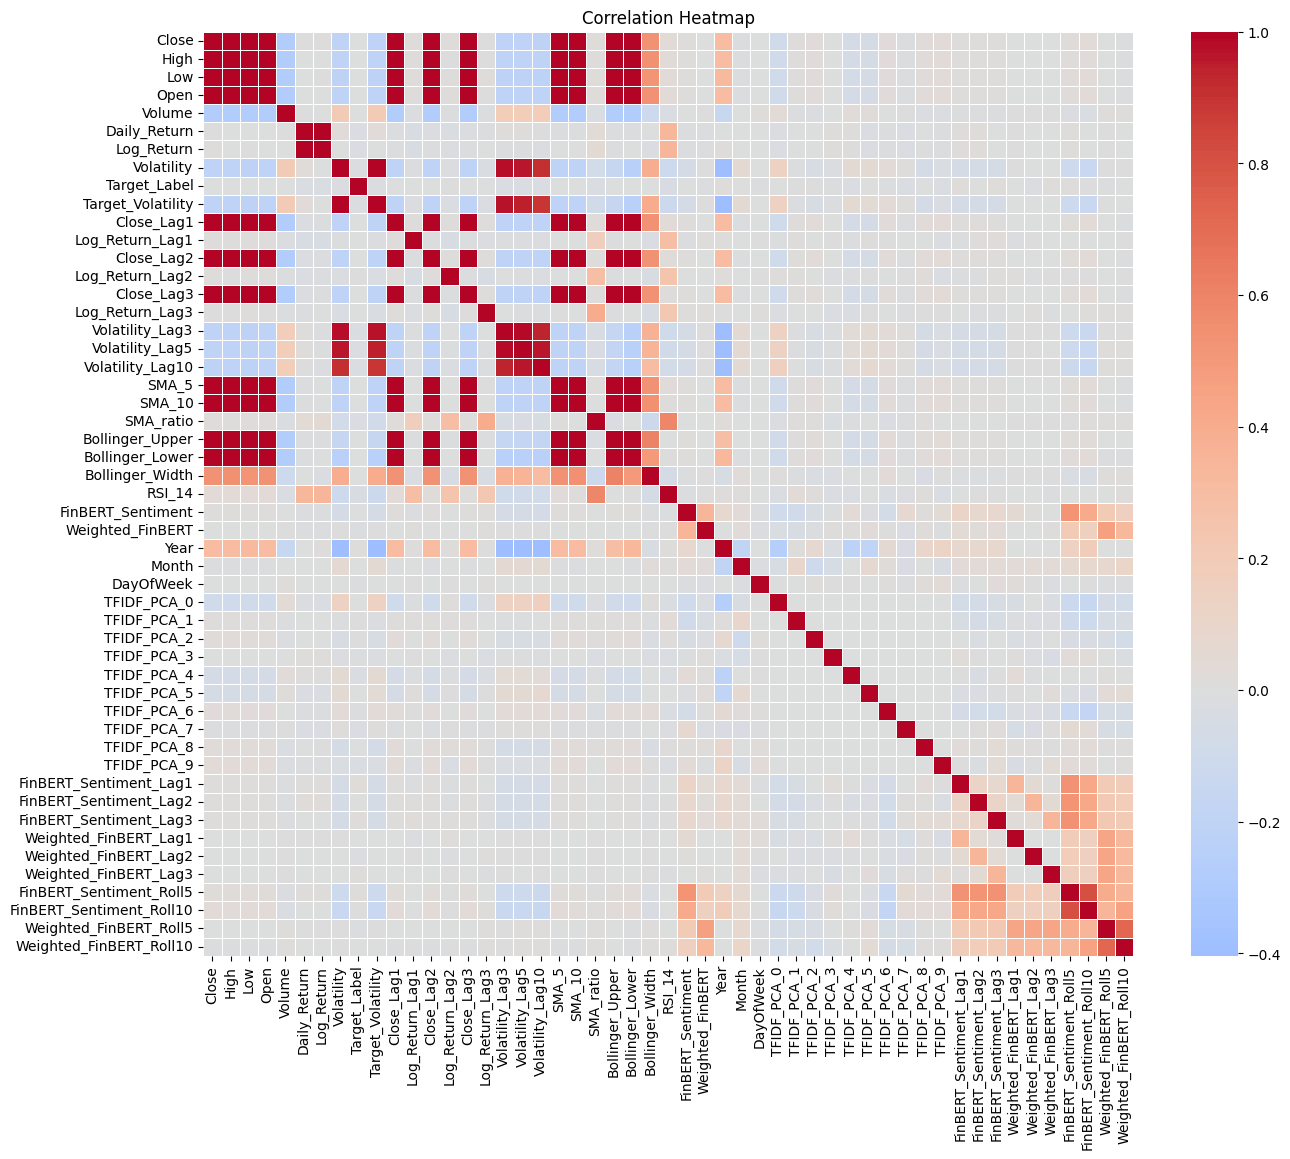

In [89]:
numeric_cols = df_final.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns

plt.figure(figsize=(15,12))
sns.heatmap(df_final[numeric_cols].corr(), cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

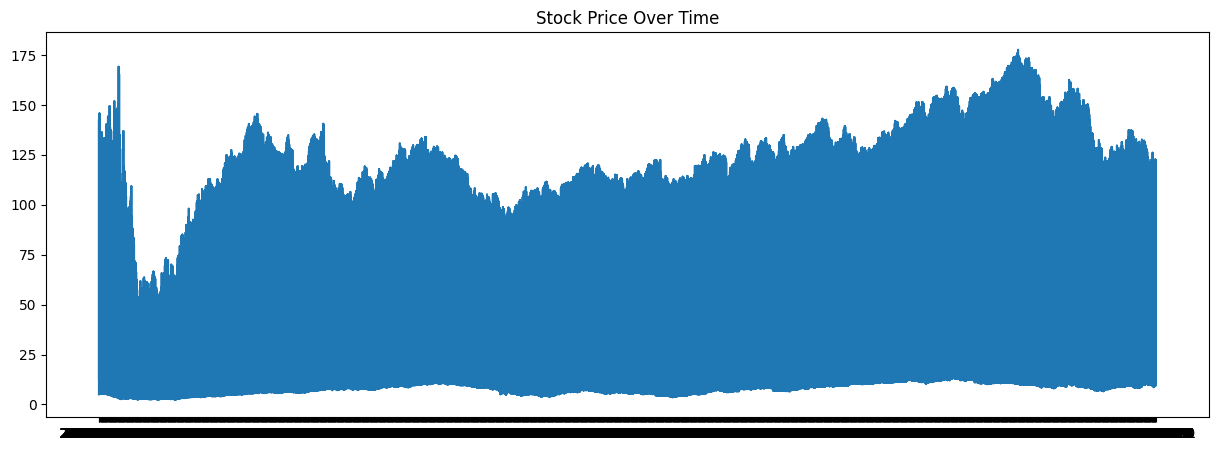

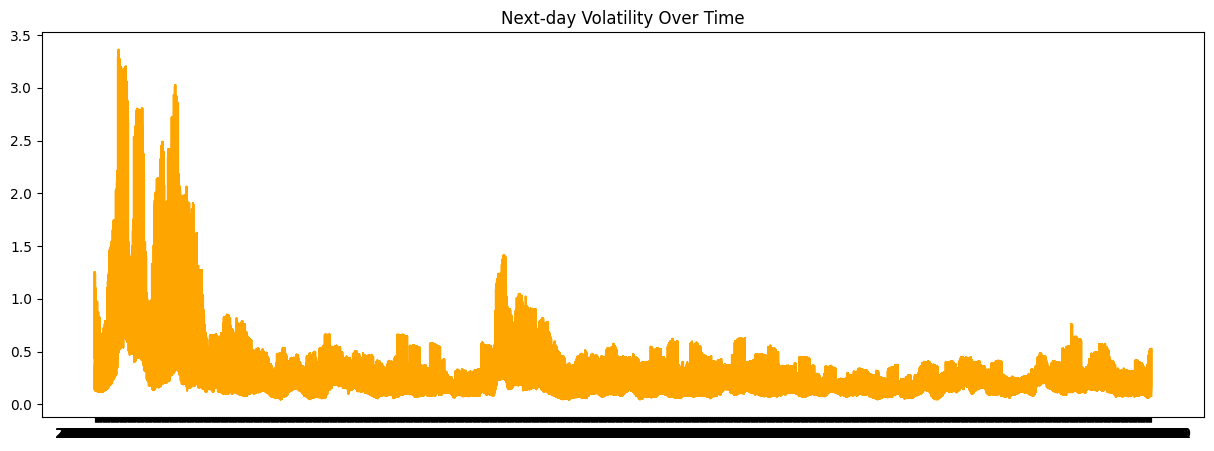

In [90]:
plt.figure(figsize=(15,5))
plt.plot(df_final['Close'], label='Close Price')
plt.title("Stock Price Over Time")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df_final['Target_Volatility'], label='Next-day Volatility', color='orange')
plt.title("Next-day Volatility Over Time")
plt.show()

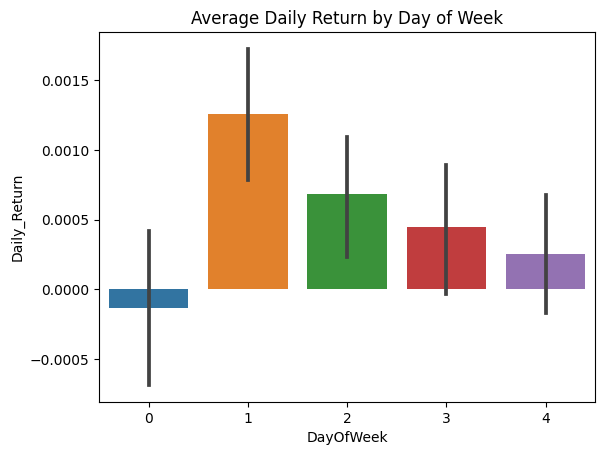

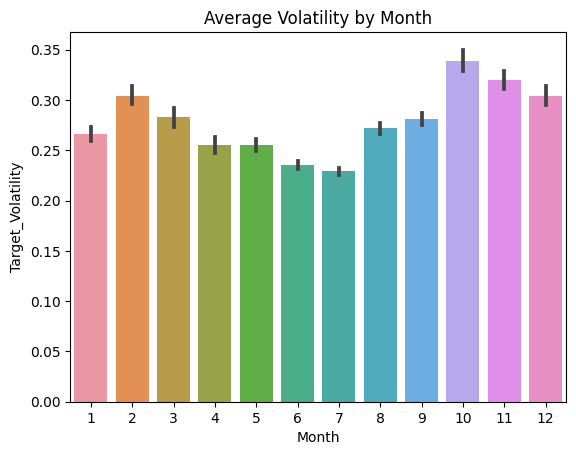

In [91]:
sns.barplot(x='DayOfWeek', y='Daily_Return', data=df_final)
plt.title("Average Daily Return by Day of Week")
plt.show()

sns.barplot(x='Month', y='Target_Volatility', data=df_final)
plt.title("Average Volatility by Month")
plt.show()

In [92]:
ticker_stats = df_final.groupby('Ticker')[['Close', 'Daily_Return', 'Log_Return', 
                                           'Volatility', 'Target_Volatility']].describe()
display(ticker_stats)

Close                                                           \
         count        mean        std        min        25%         50%   
Ticker                                                                    
AAPL    1989.0   14.535703   7.619526   2.347573   7.834052   13.894002   
AXP     1989.0   48.254677  18.897888   7.972335  33.957748   47.281025   
BAC     1989.0   10.793358   3.486506   2.442877   8.876821   11.226942   
C       1989.0   35.342060  18.384321   7.613555  27.485451   33.312103   
CAT     1989.0   56.974821  16.311703  14.442927  46.724213   61.234440   
CSCO    1989.0   15.247912   3.323689   8.913499  12.535295   15.052160   
GS      1989.0  117.574631  27.180480  38.961990  98.843376  122.758583   
HD      1989.0   47.440574  28.752624  11.904276  22.115419   38.561111   
HPQ     1989.0   10.072122   2.798945   3.611841   7.953532   10.214339   
IBM     1989.0   92.510599  21.393113  38.916187  72.655167   97.210388   
INTC    1989.0   17.559900   5.336561   7.641389  13.676051   16.591732   
JNJ     1989.0   54.494135  16.840010  28.588470  40.404659   46.650021   
JPM     1989.0   33.769496   9.760374  10.586081  26.077391   30.470451   
KO      1989.0   23.707812   6.053379  11.344920  17.789539   25.066395   
MCD     1989.0   61.939526  17.128740  32.070713  46.840572   65.348282   
MS      1989.0   19.333721   5.287136   6.416046  15.842723   19.640179   
MSFT    1989.0   27.107313   9.670496  11.159396  19.843925   23.289225   
ORCL    1989.0   26.180821   6.906864  11.122159  20.542631   26.529081   
PEP     1989.0   51.532302  13.916618  28.015953  41.222515   46.969761   
PG      1989.0   48.748939  10.277579  27.296030  40.483875   45.733303   
USB     1989.0   21.426414   6.596323   5.490657  15.641260   21.135695   
V       1989.0   35.304116  20.096110   9.411070  17.112045   28.803017   
WFC     1989.0   26.393917   9.337763   5.354461  18.572031   23.126808   
WMT     1989.0   16.508761   3.595107  10.879990  13.014230   16.594698   

                               Daily_Return            ... Volatility  \
               75%         max        count      mean  ...        75%   
Ticker                                                 ...              
AAPL     20.912605   29.650921       1989.0  0.000954  ...   0.322869   
AXP      65.148567   81.613991       1989.0  0.000659  ...   0.345958   
BAC      12.871423   28.924557       1989.0  0.000386  ...   0.464103   
C        38.053047  169.147766       1989.0  0.000141  ...   0.470152   
CAT      67.721390   83.126160       1989.0  0.000409  ...   0.369794   
CSCO     17.655773   21.963110       1989.0  0.000363  ...   0.333787   
GS      133.925125  177.647644       1989.0  0.000312  ...   0.337285   
HD       62.387634  109.668022       1989.0  0.001091  ...   0.271813   
HPQ      12.231882   16.170801       1989.0  0.000090  ...   0.393708   
IBM     111.025459  126.355301       1989.0  0.000276  ...   0.247450   
INTC     22.501236   28.901516       1989.0  0.000465  ...   0.293584   
JNJ      73.036140   93.877213       1989.0  0.000460  ...   0.170790   
JPM      42.645382   53.346733       1989.0  0.000724  ...   0.370711   
KO       28.798235   35.019726       1989.0  0.000455  ...   0.185112   
MCD      72.133209  104.566254       1989.0  0.000535  ...   0.193776   
MS       22.992325   31.265270       1989.0  0.000557  ...   0.438118   
MSFT     35.253292   49.885117       1989.0  0.000586  ...   0.279163   
ORCL     32.329189   39.261951       1989.0  0.000504  ...   0.292902   
PEP      64.275246   80.300339       1989.0  0.000407  ...   0.178621   
PG       58.388069   69.220222       1989.0  0.000305  ...   0.186971   
USB      28.315451   32.306950       1989.0  0.000554  ...   0.333287   
V        50.020374   76.561569       1989.0  0.000956  ...   0.308807   
WFC      36.459183   43.769444       1989.0  0.000820  ...   0.368155   
WMT      19.883539   24.504387       1989.0  0.000297  ...   0.195904   

           

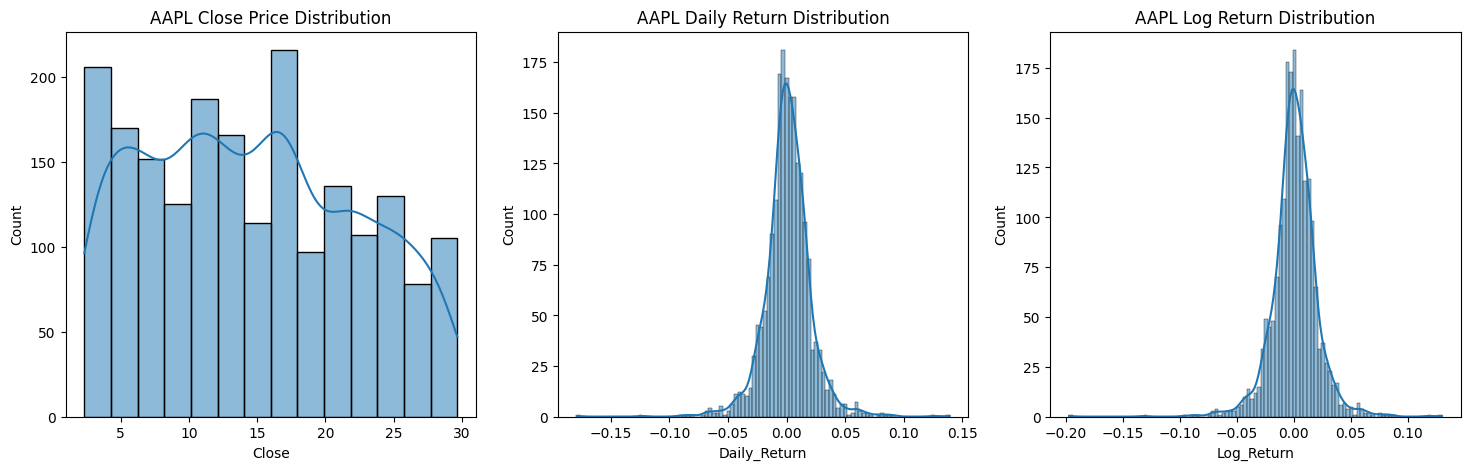

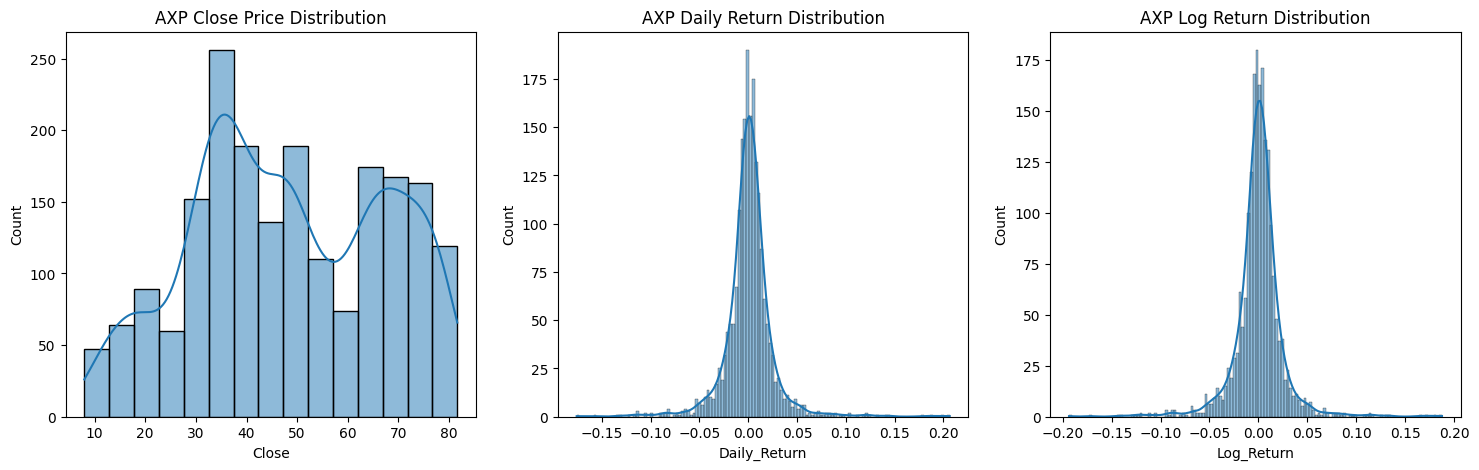

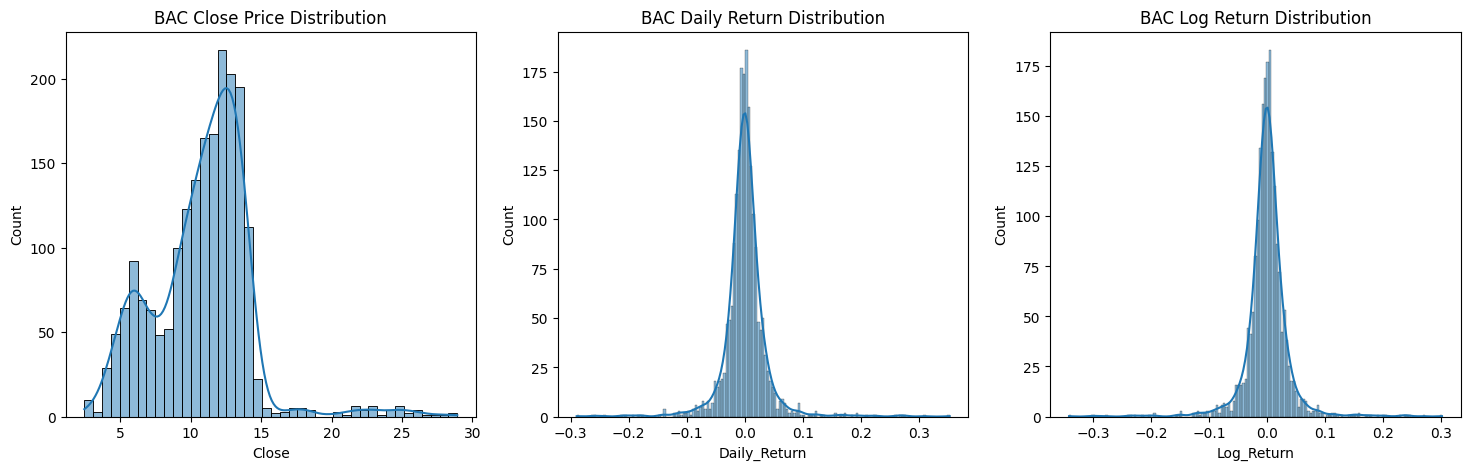

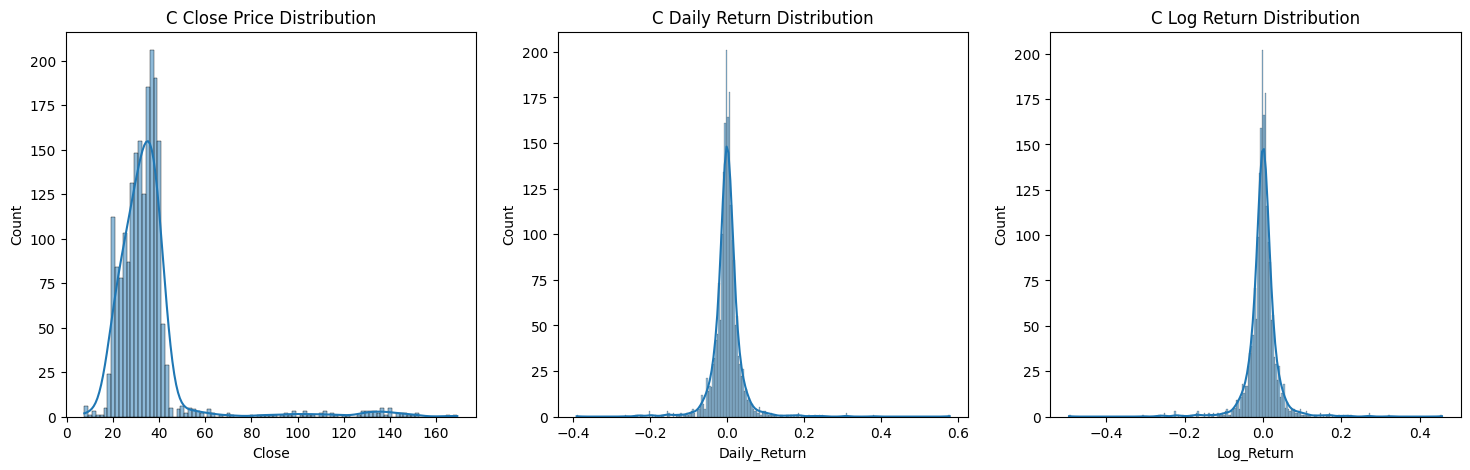

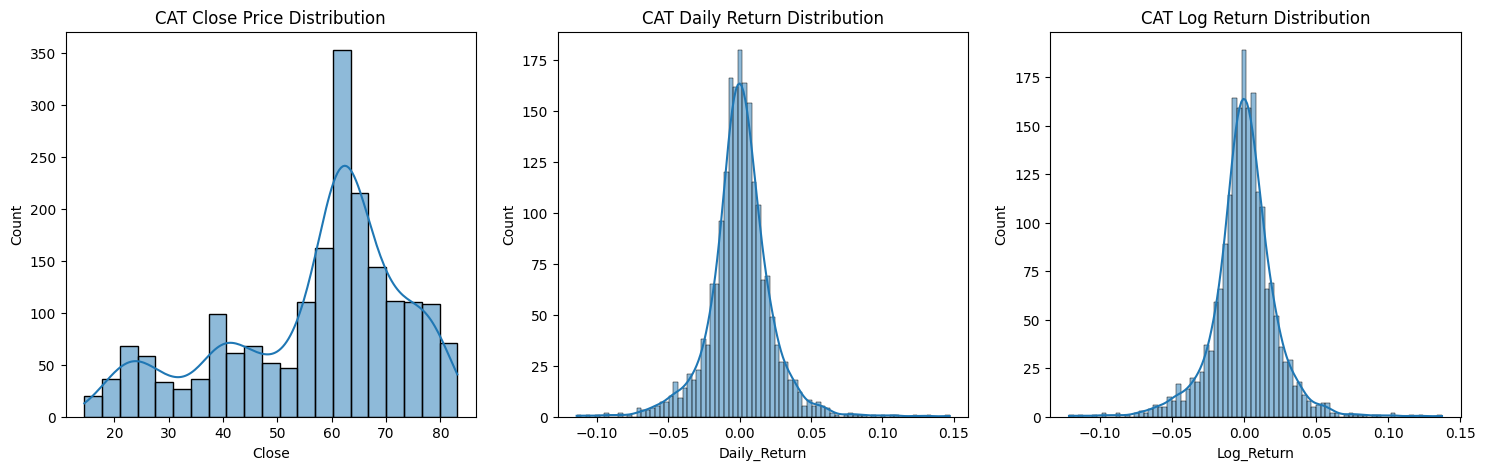

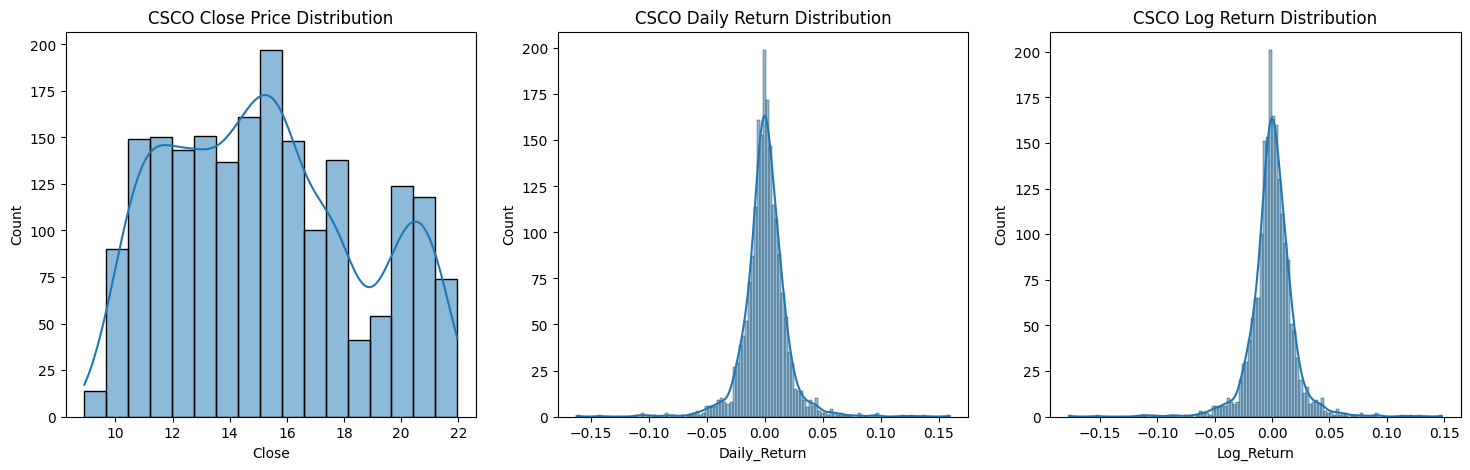

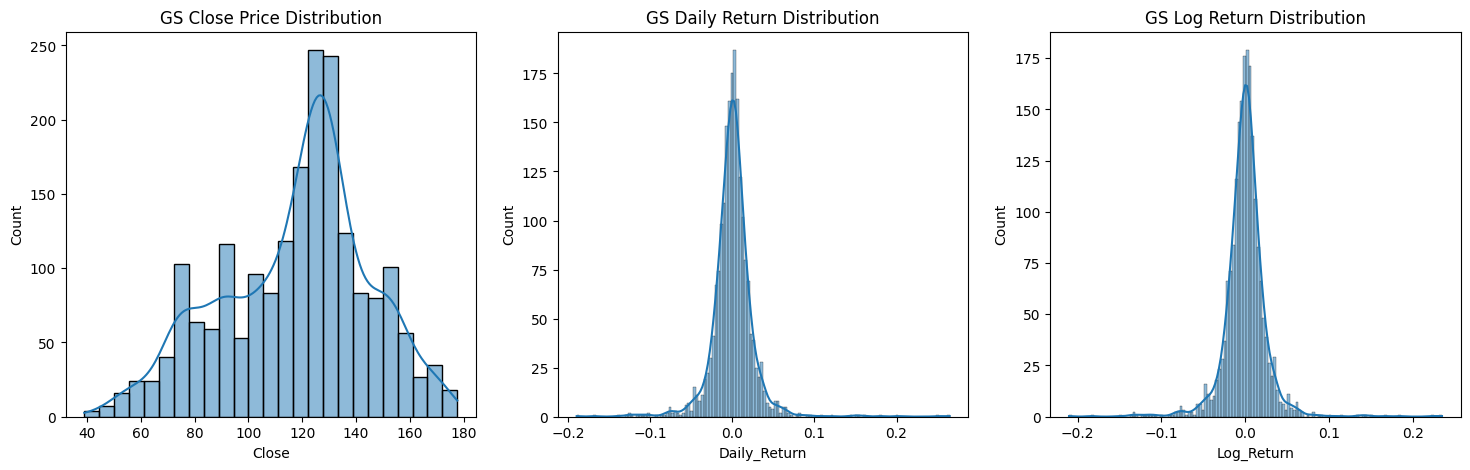

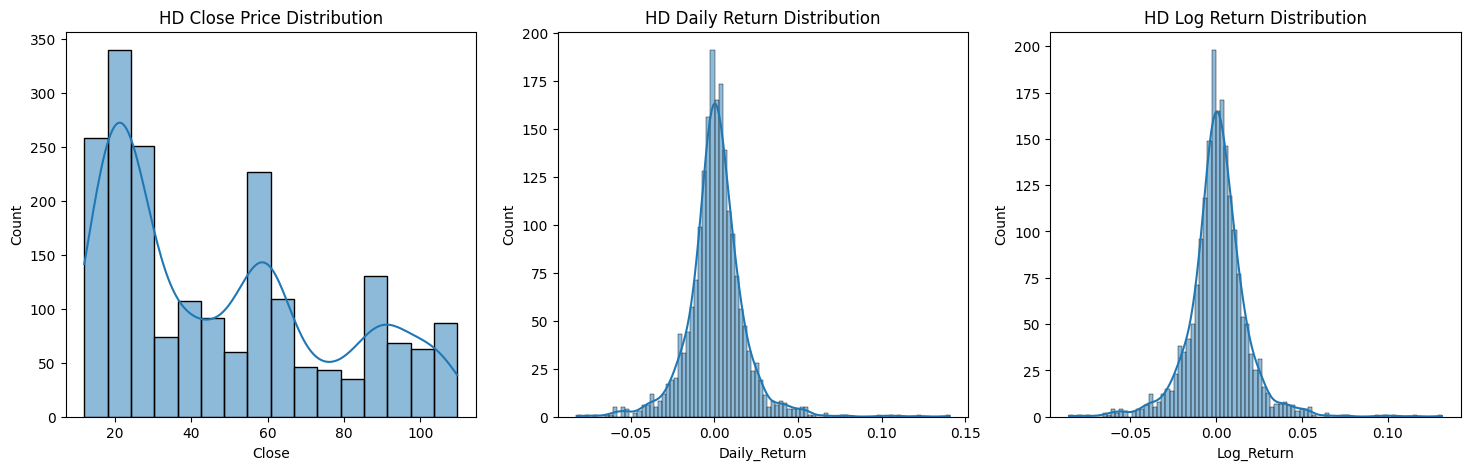

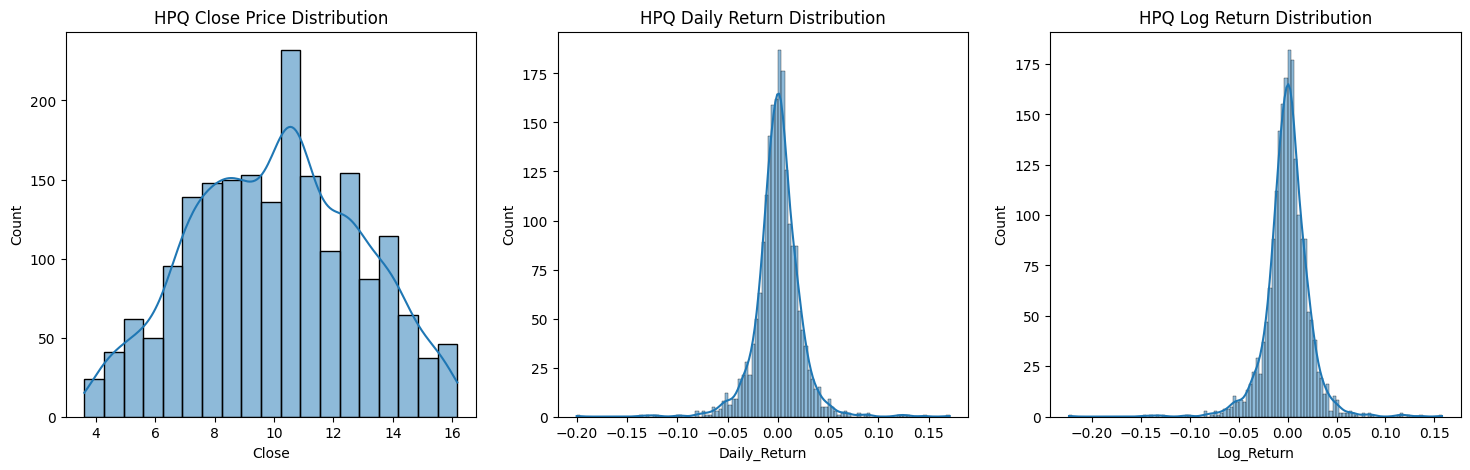

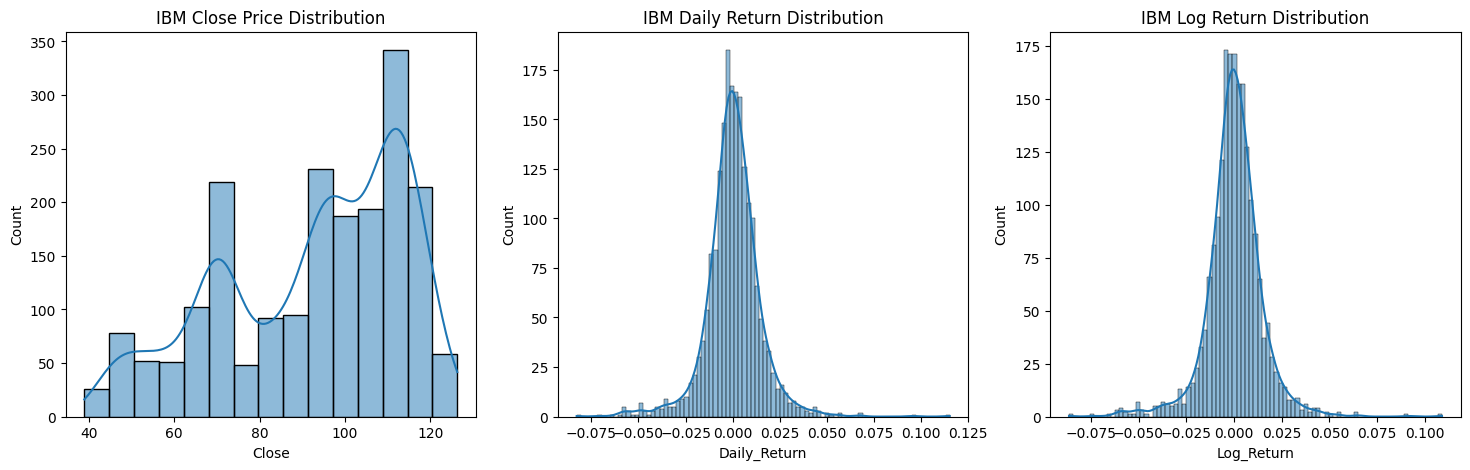

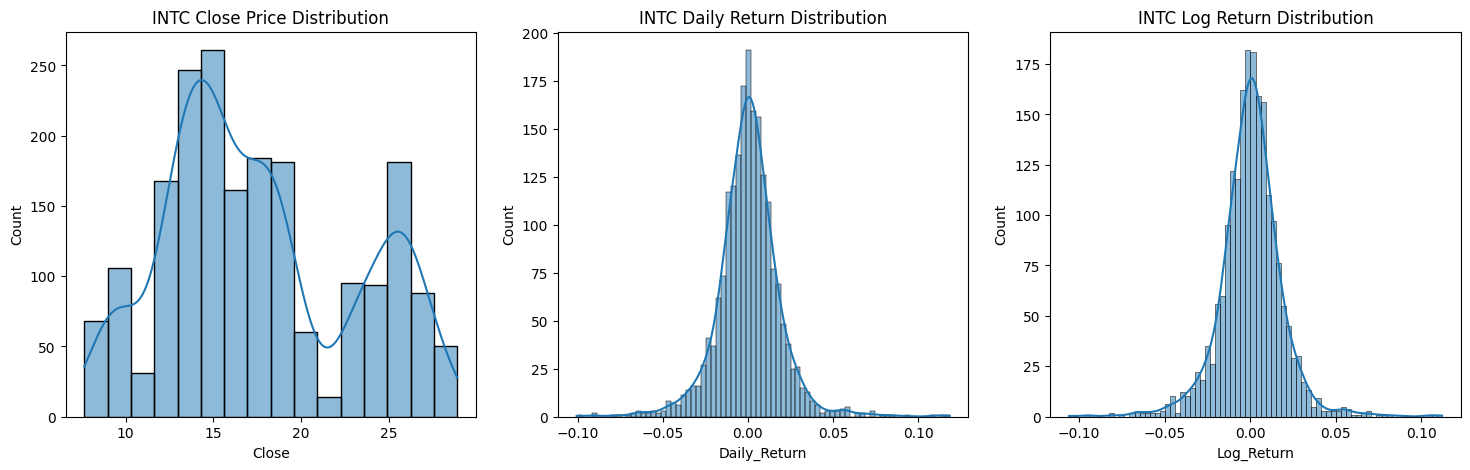

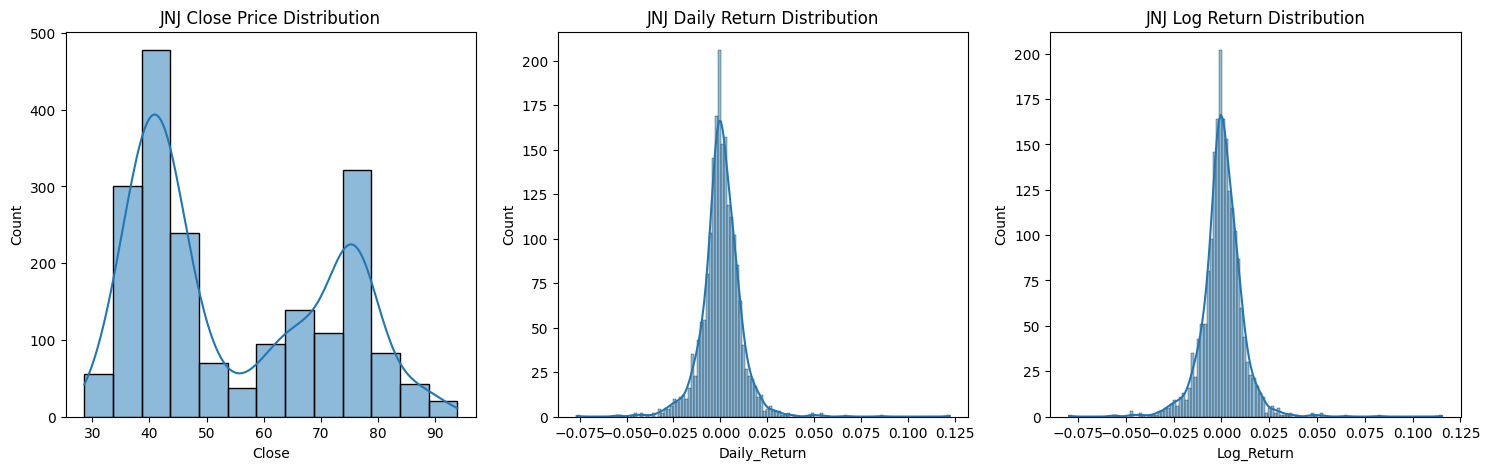

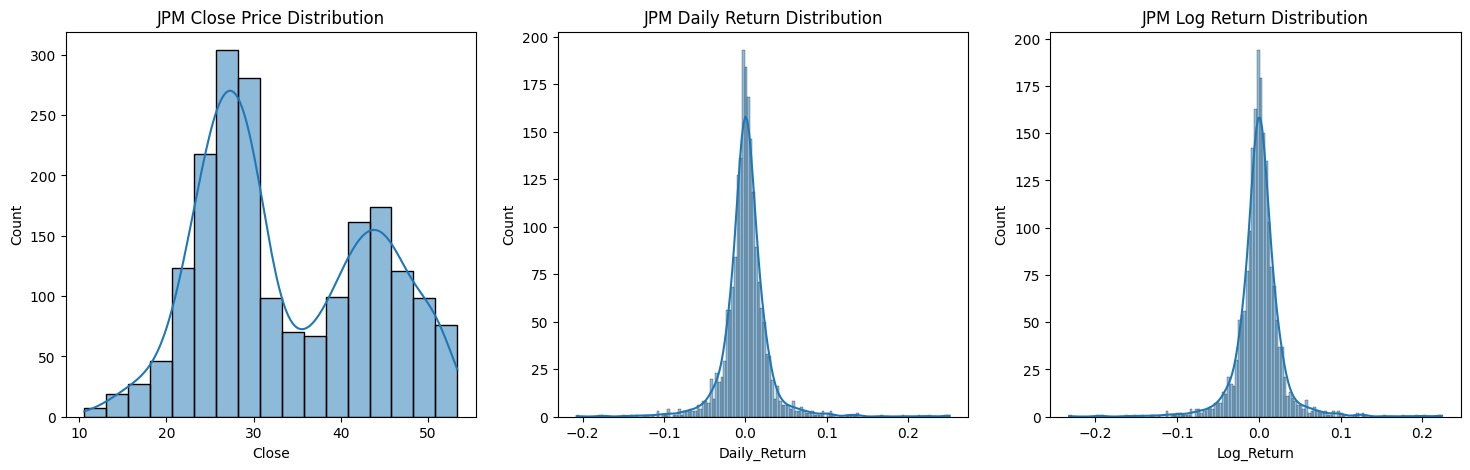

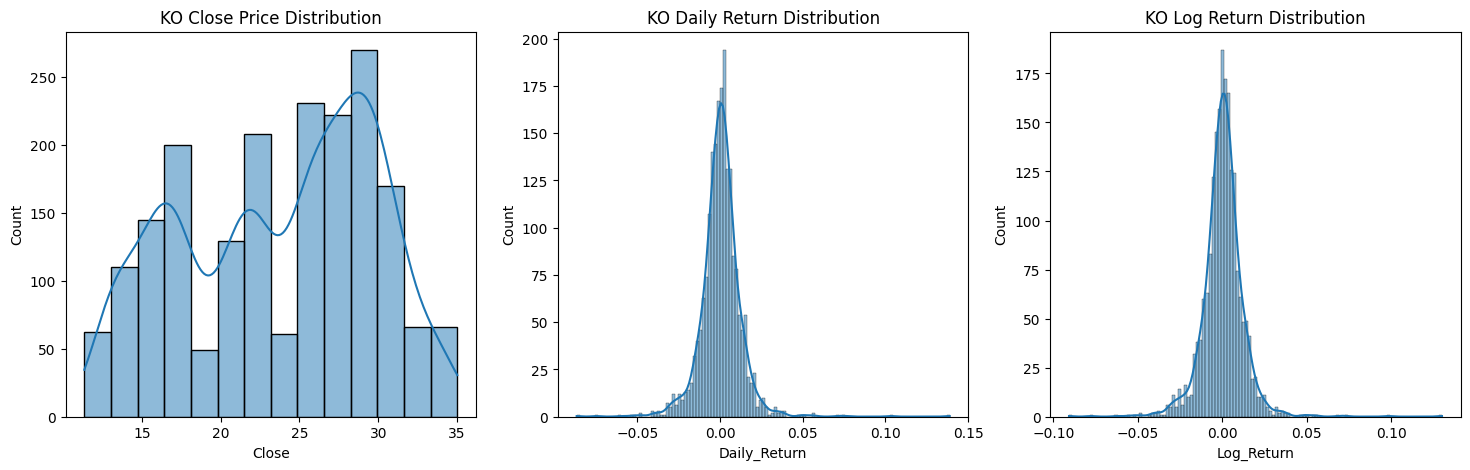

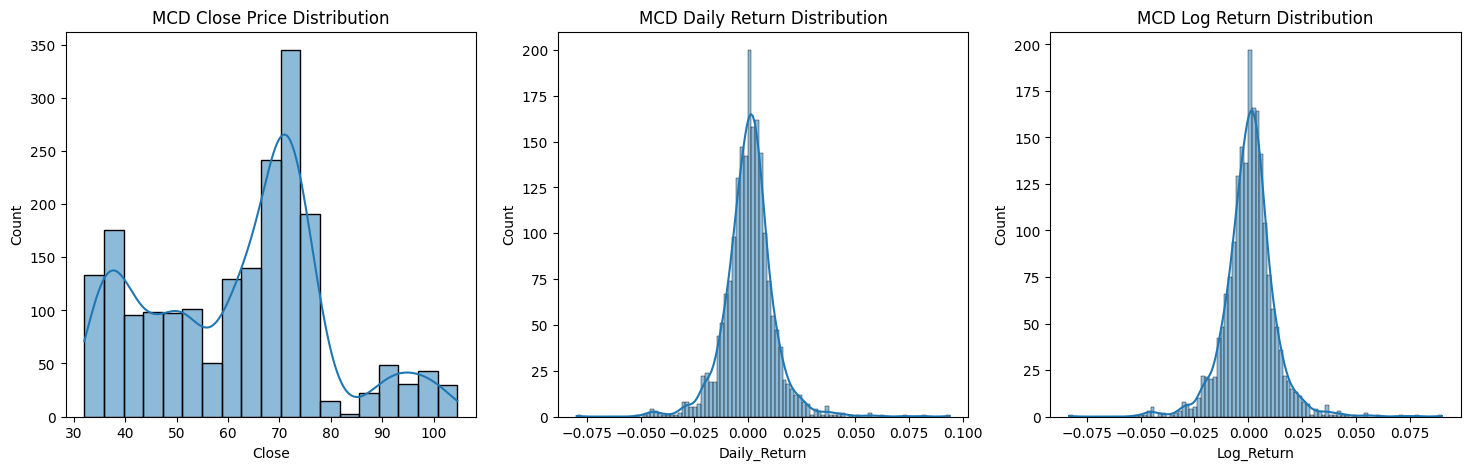

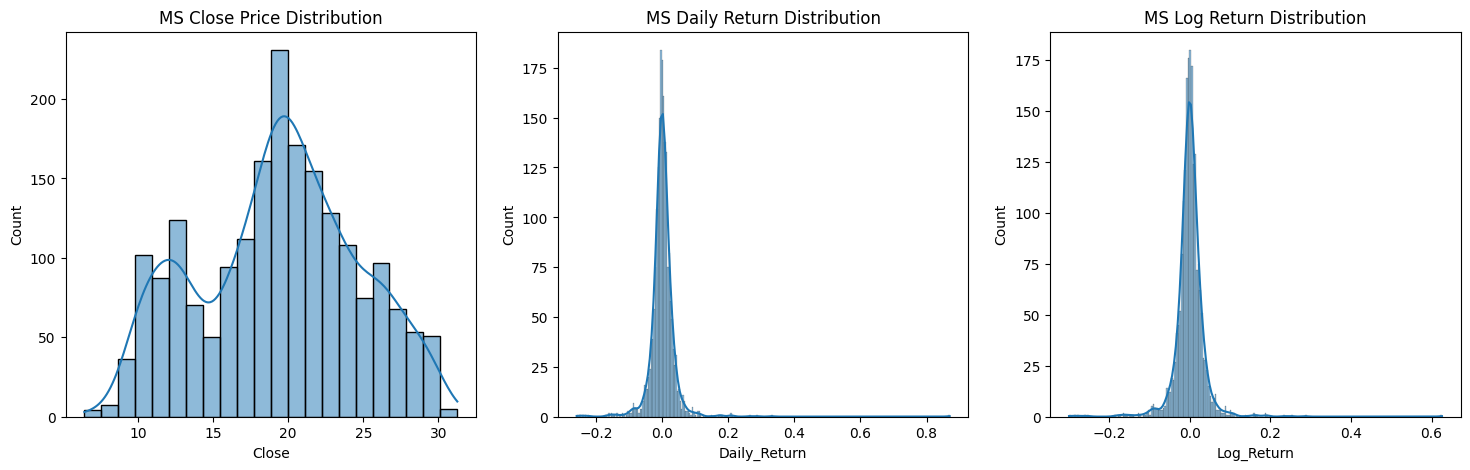

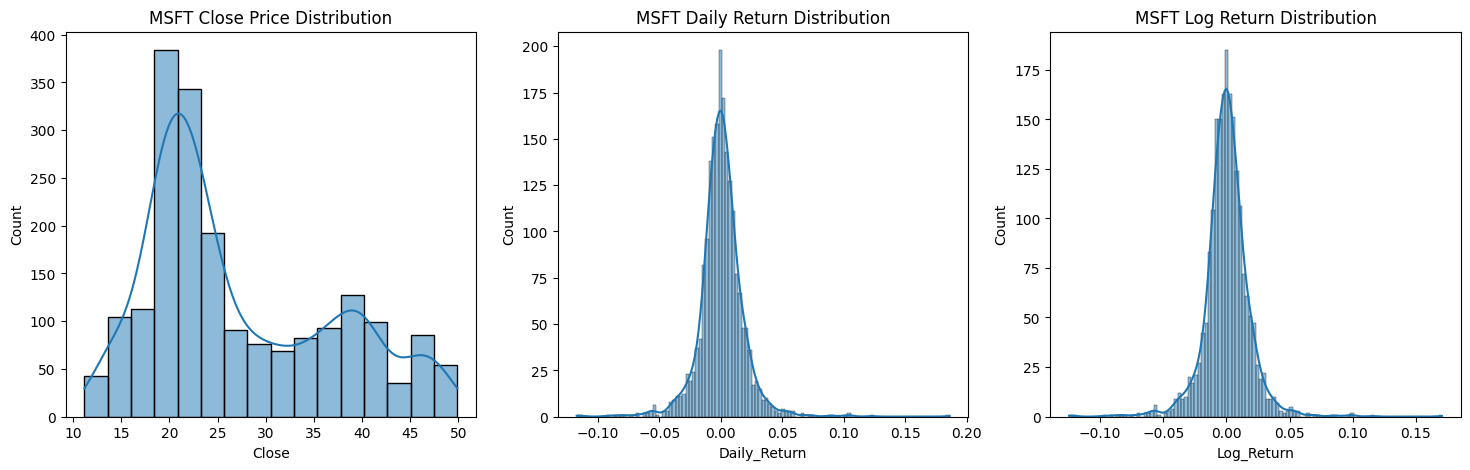

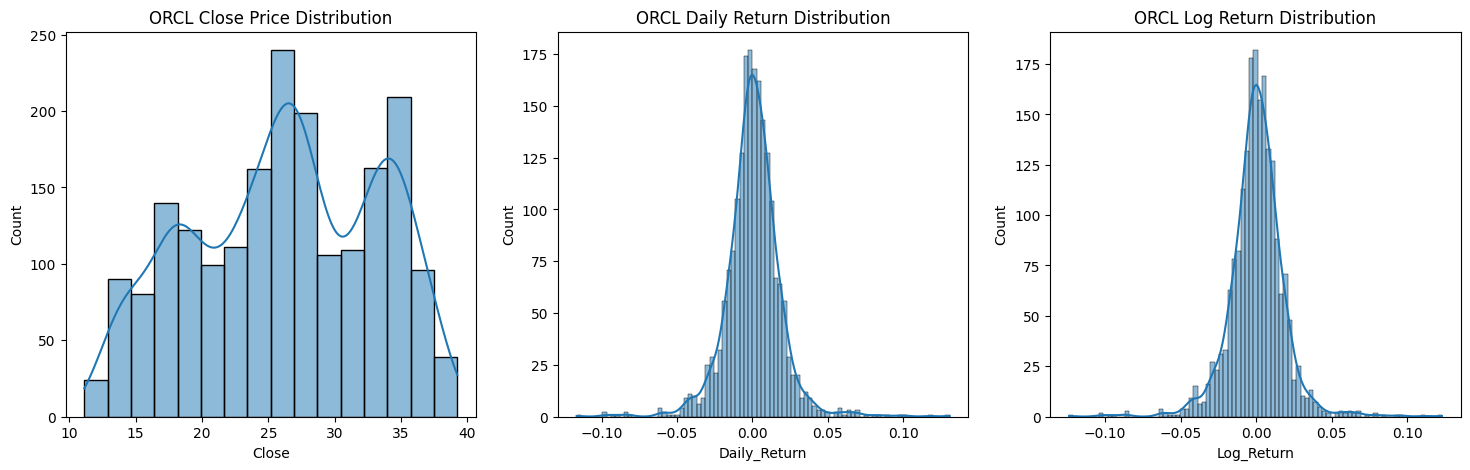

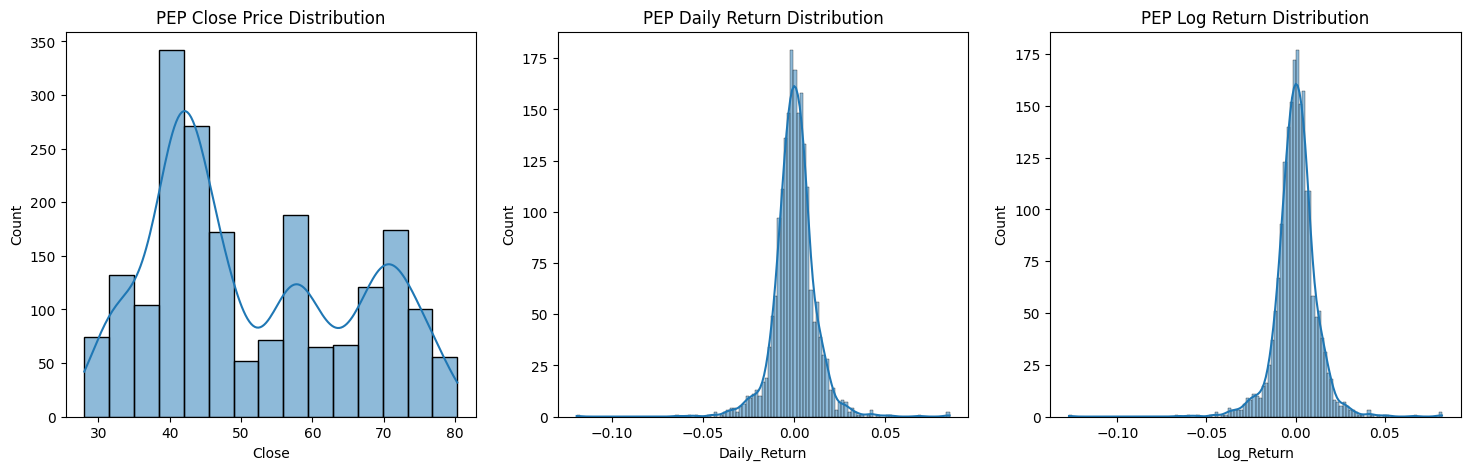

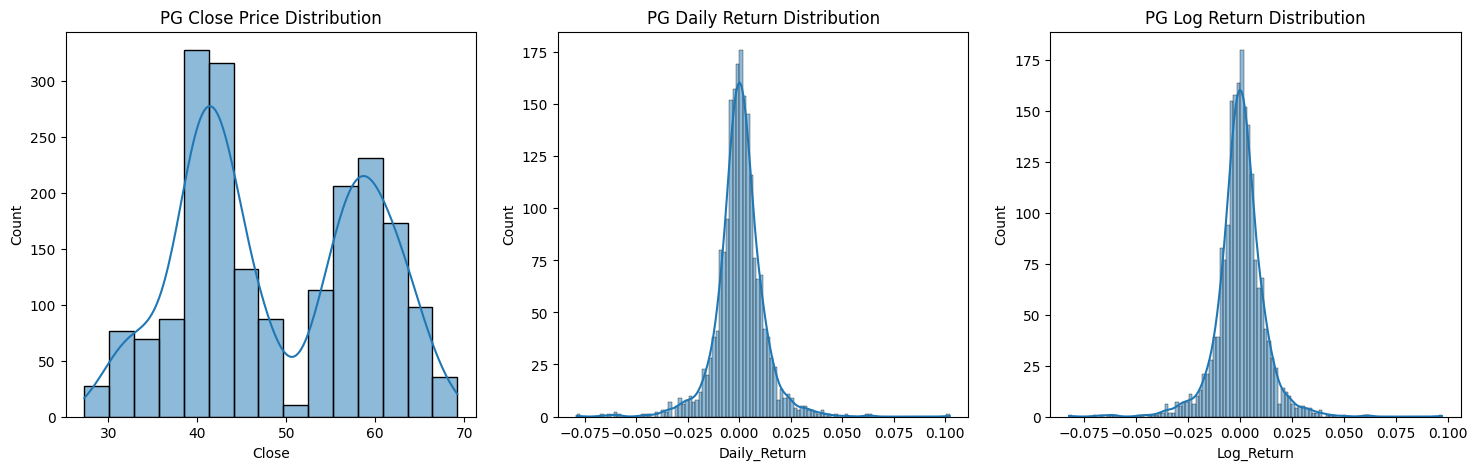

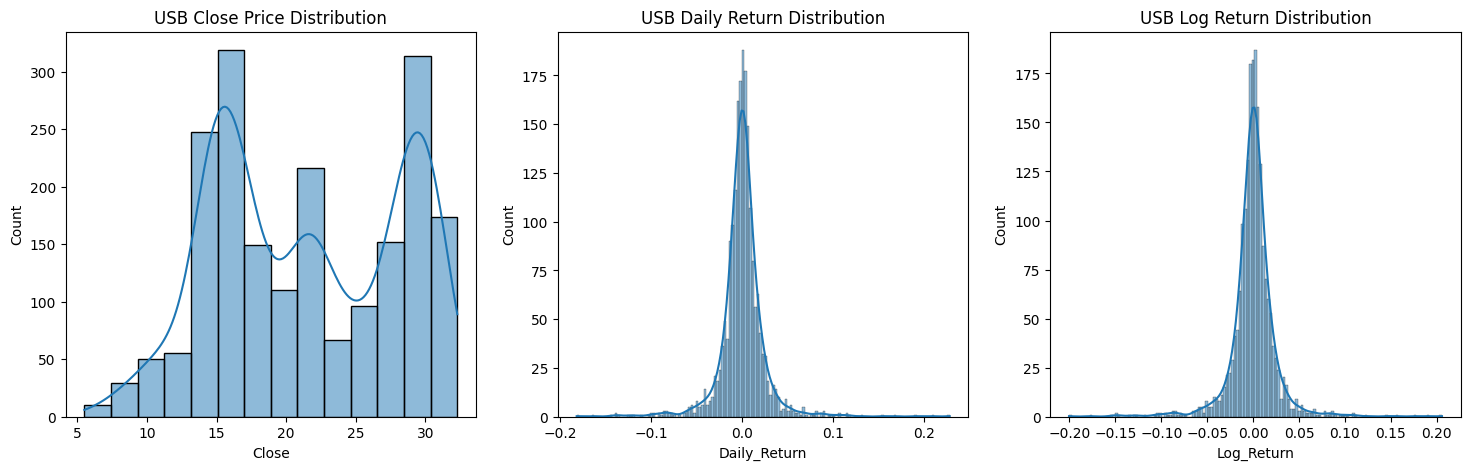

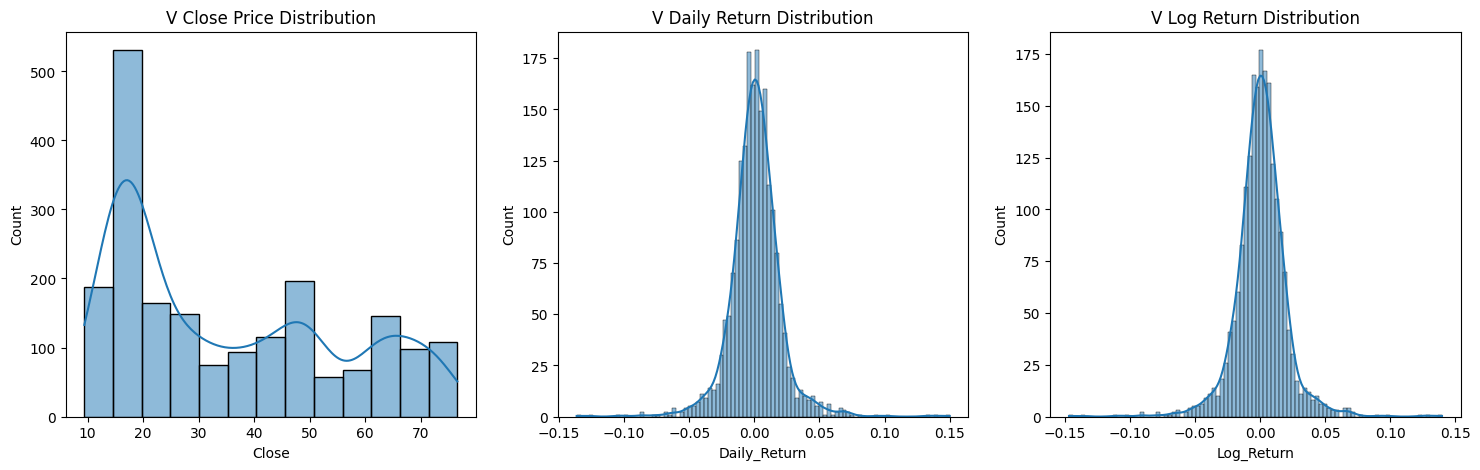

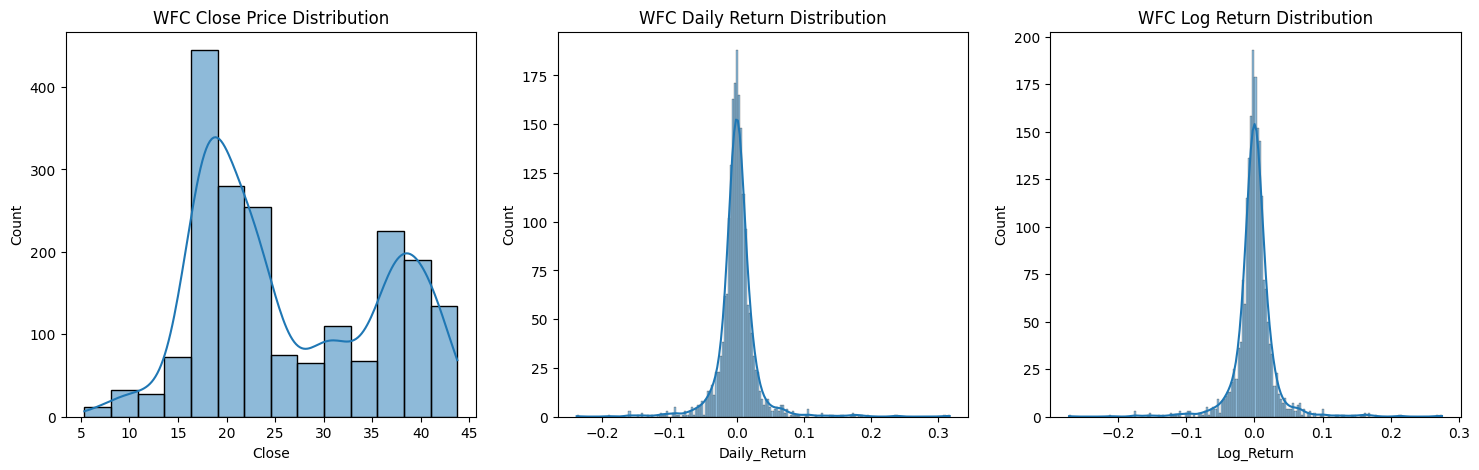

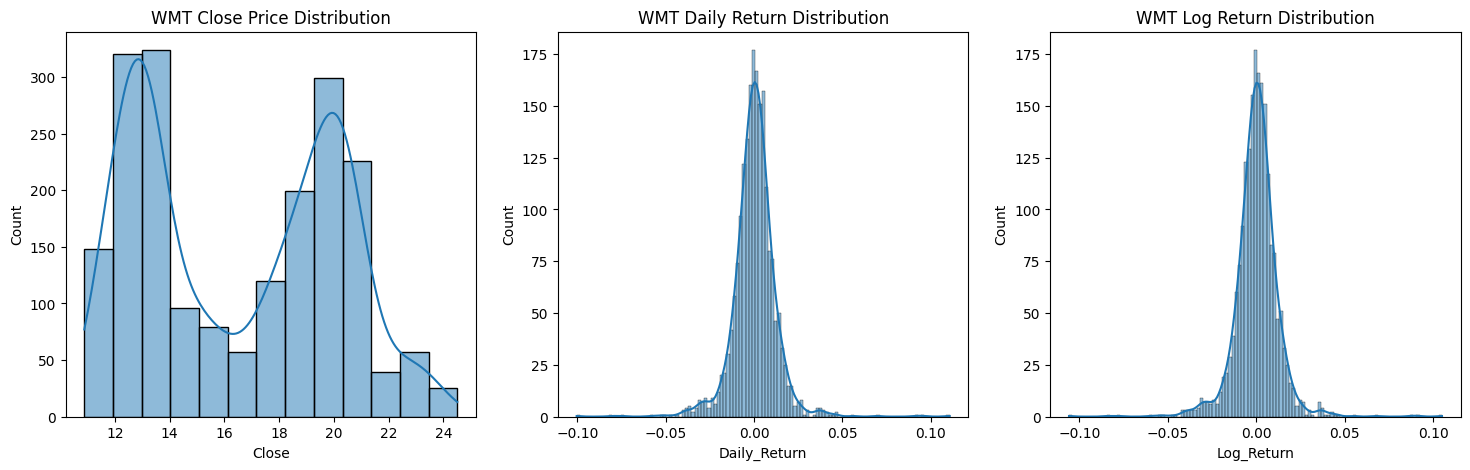

In [93]:
for t in df_final['Ticker'].unique():
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    sns.histplot(df_final[df_final['Ticker']==t]['Close'], kde=True, ax=axes[0])
    axes[0].set_title(f'{t} Close Price Distribution')
    
    sns.histplot(df_final[df_final['Ticker']==t]['Daily_Return'], kde=True, ax=axes[1])
    axes[1].set_title(f'{t} Daily Return Distribution')
    
    sns.histplot(df_final[df_final['Ticker']==t]['Log_Return'], kde=True, ax=axes[2])
    axes[2].set_title(f'{t} Log Return Distribution')
    
    plt.show()

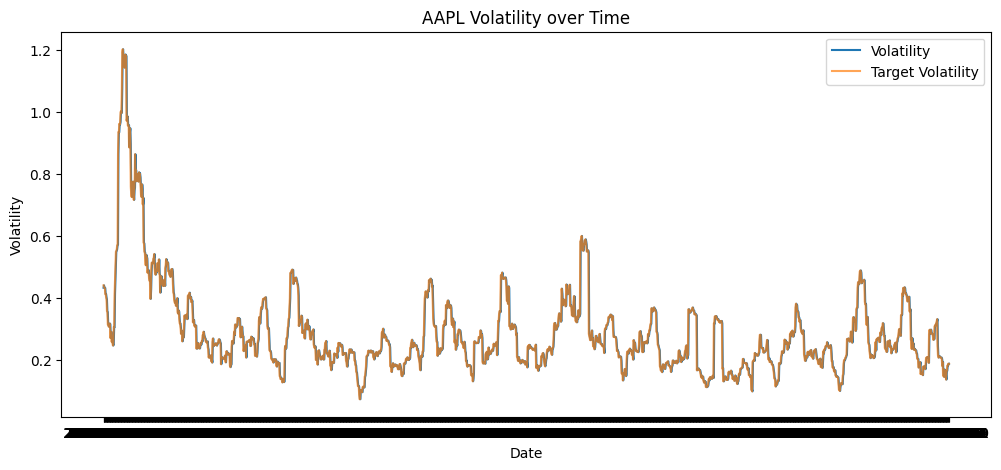

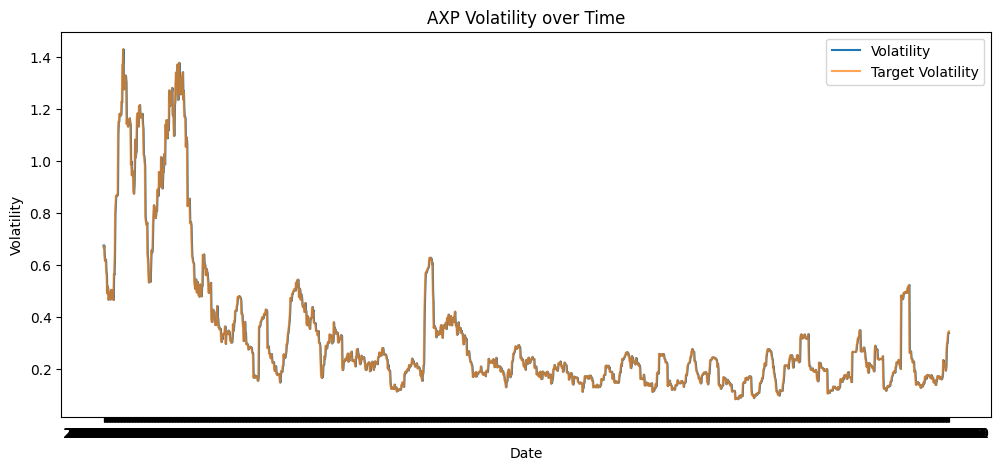

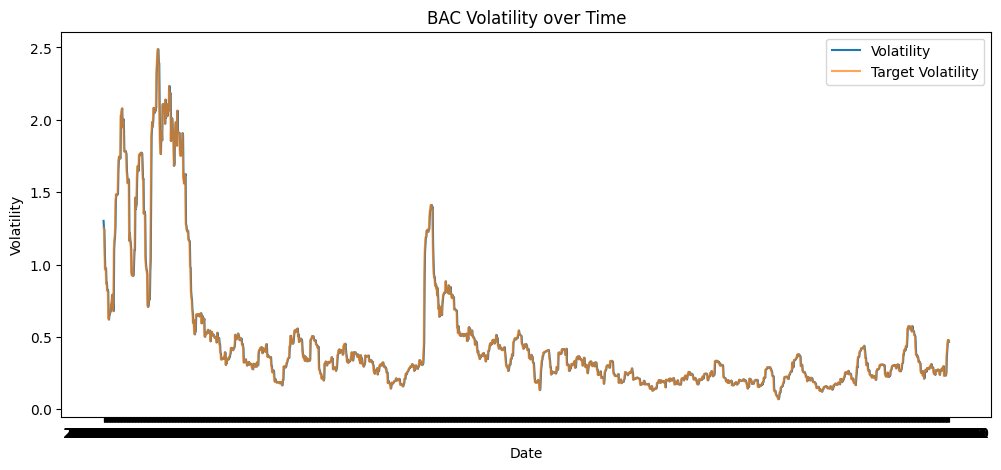

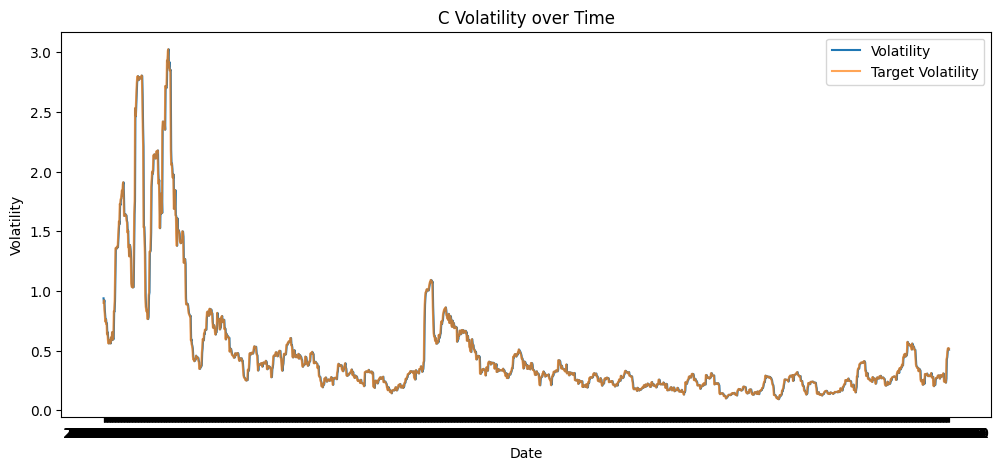

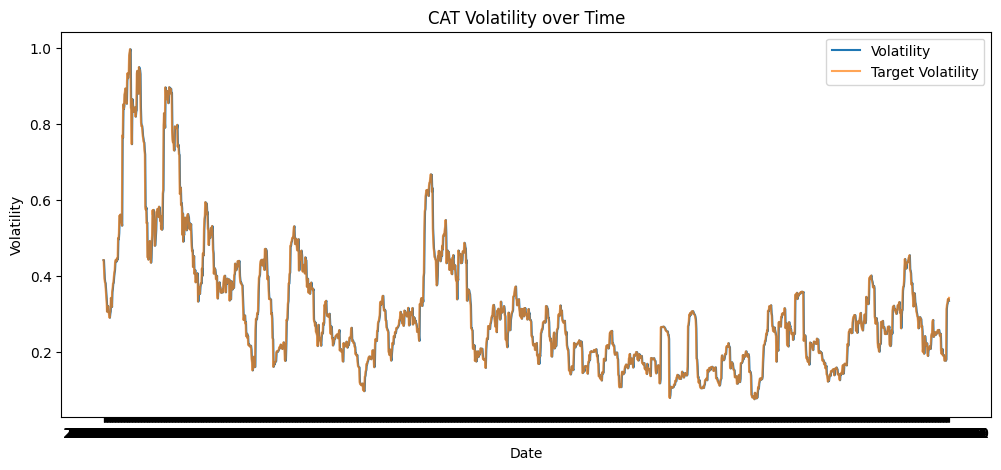

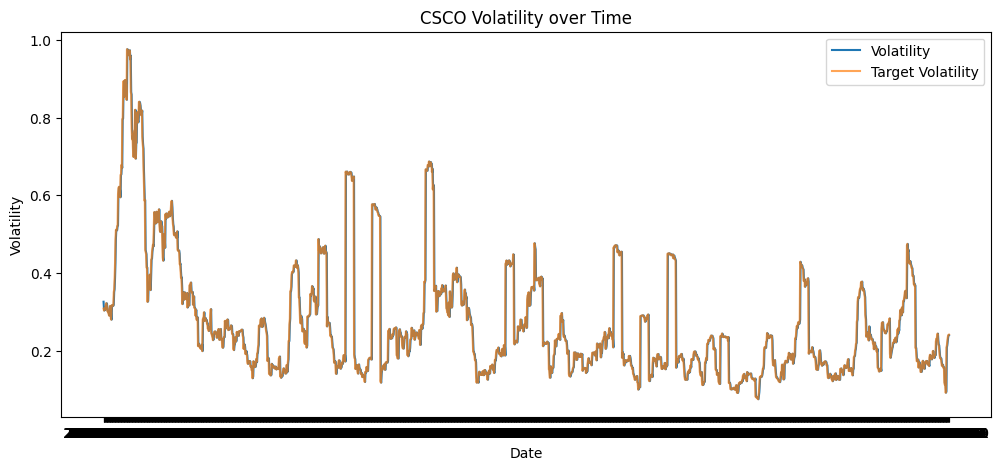

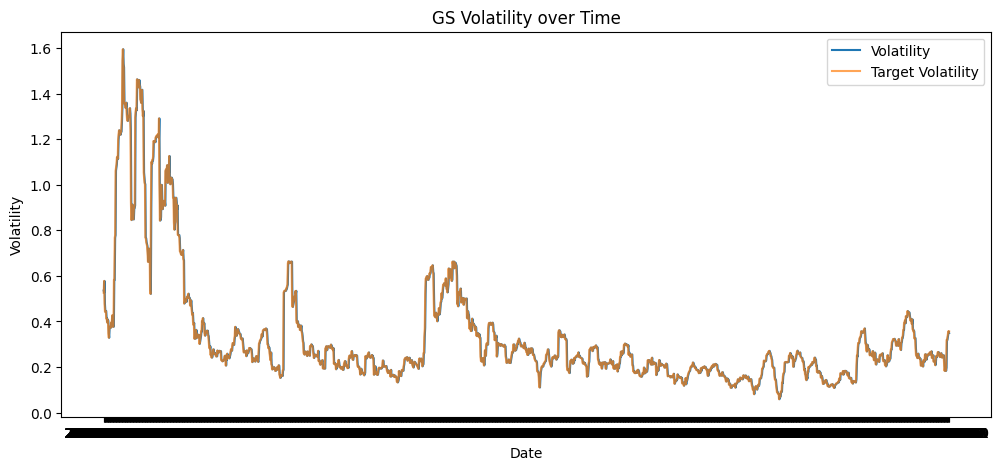

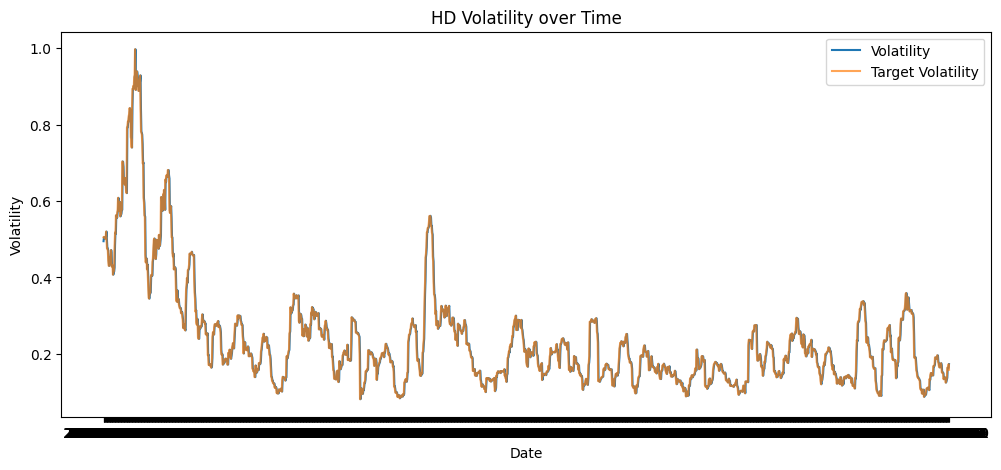

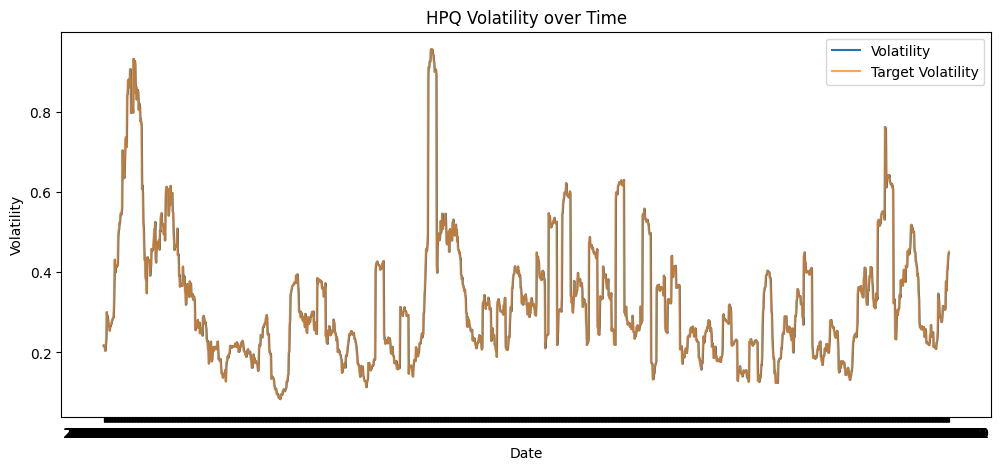

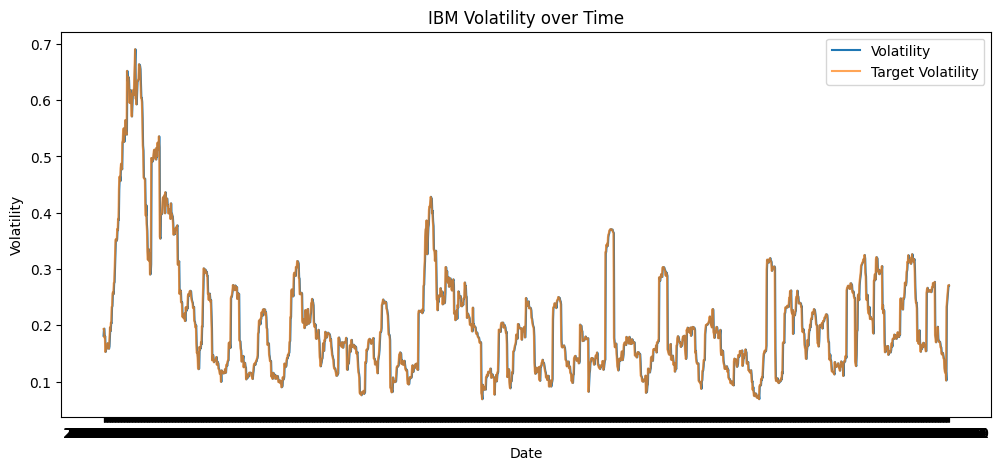

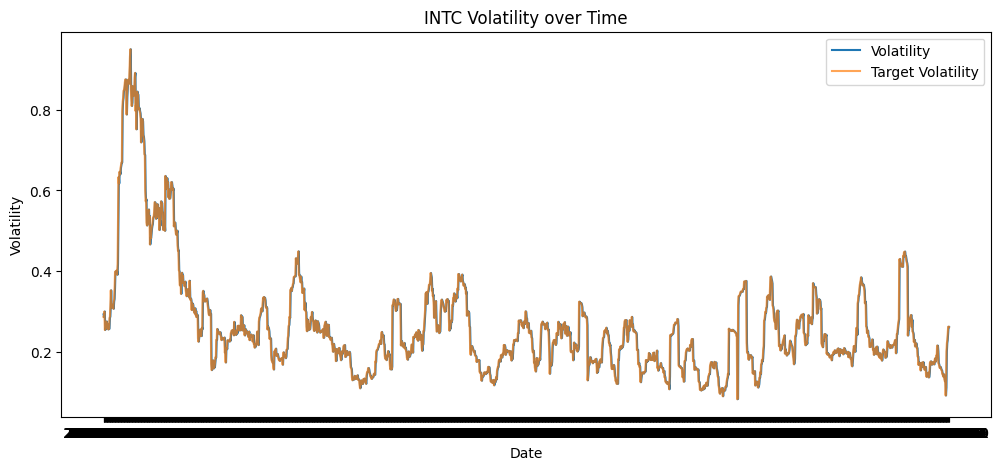

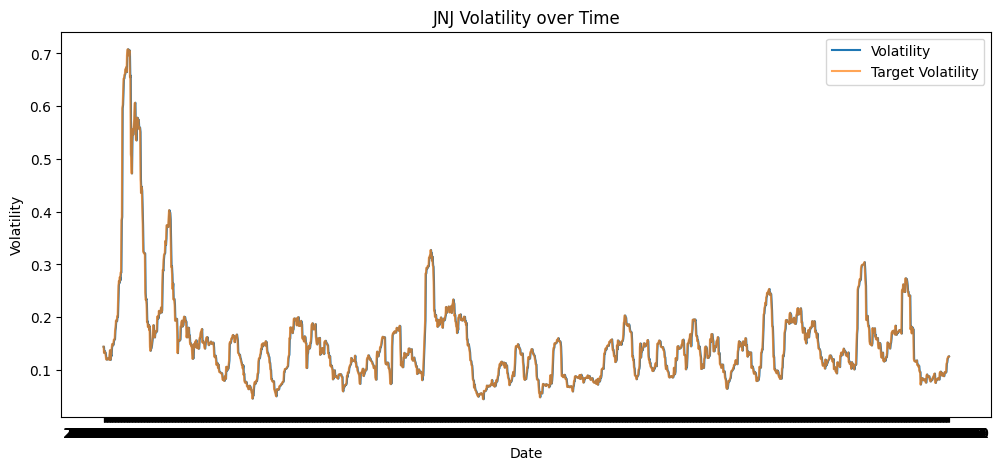

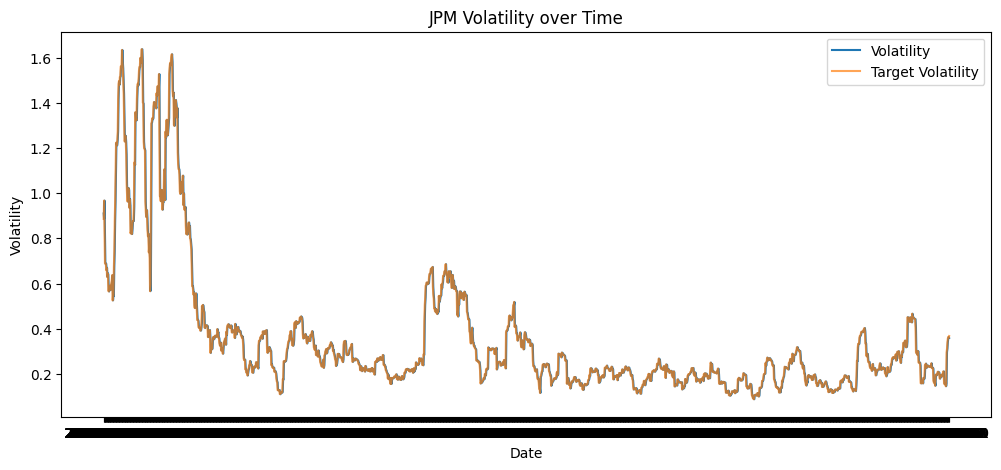

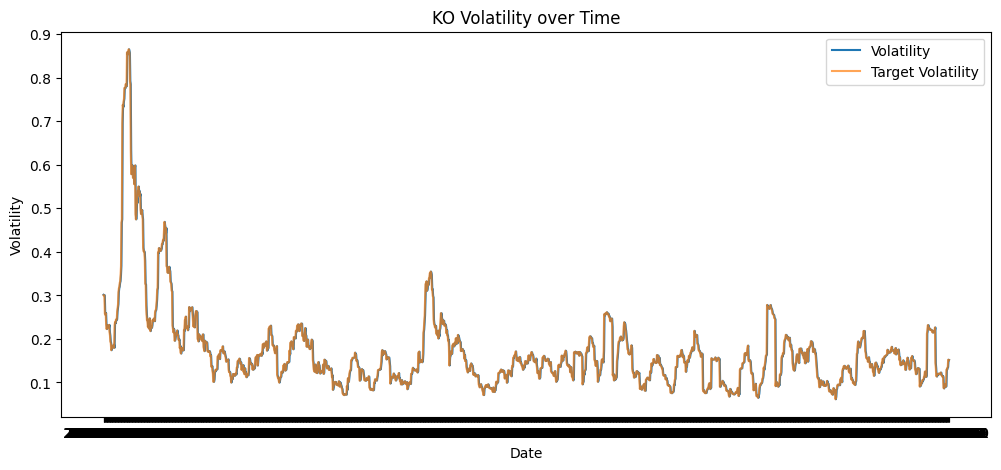

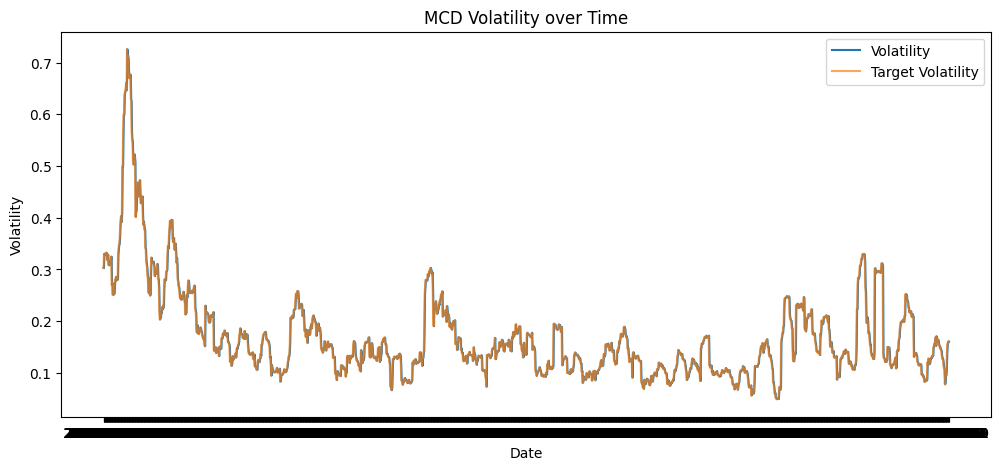

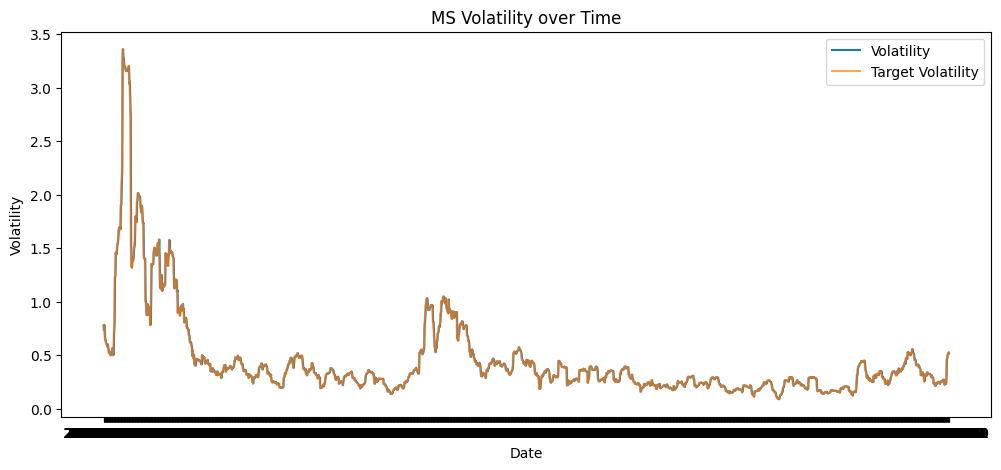

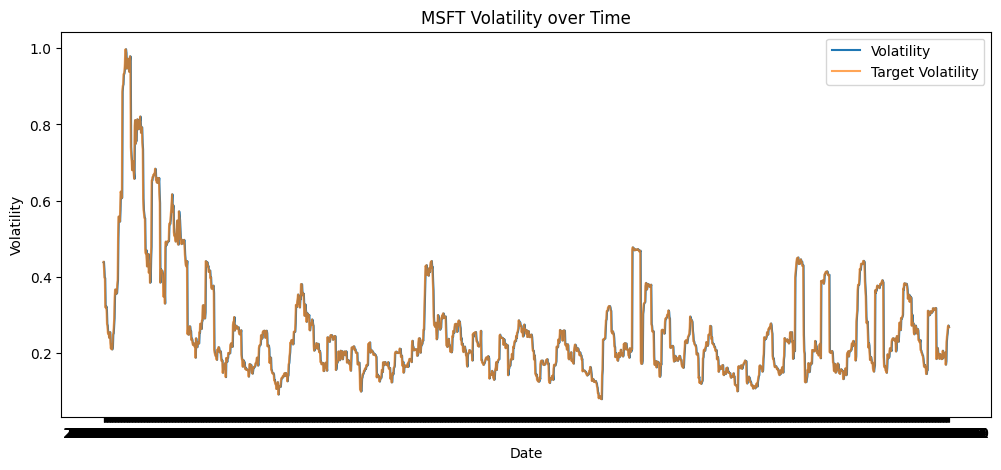

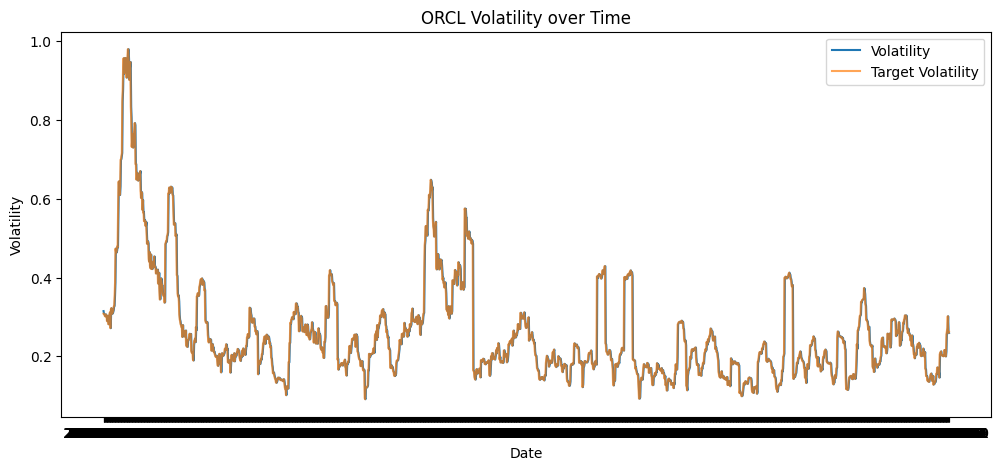

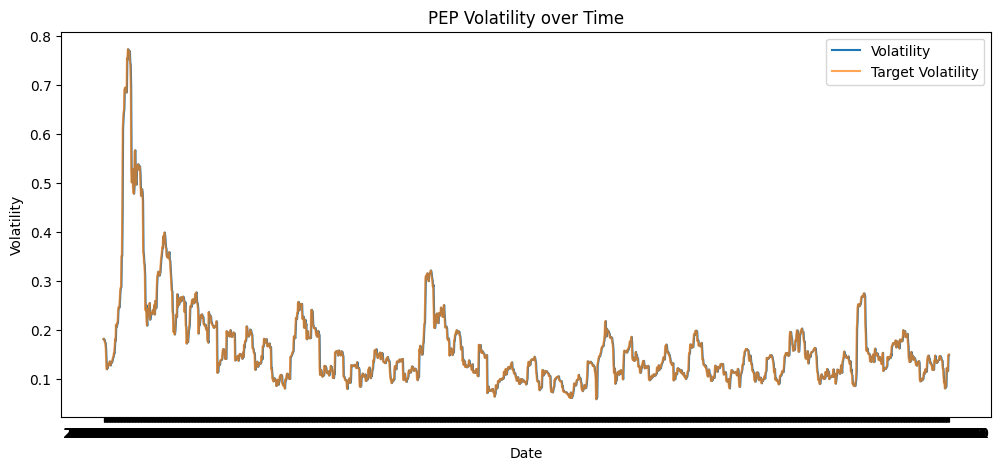

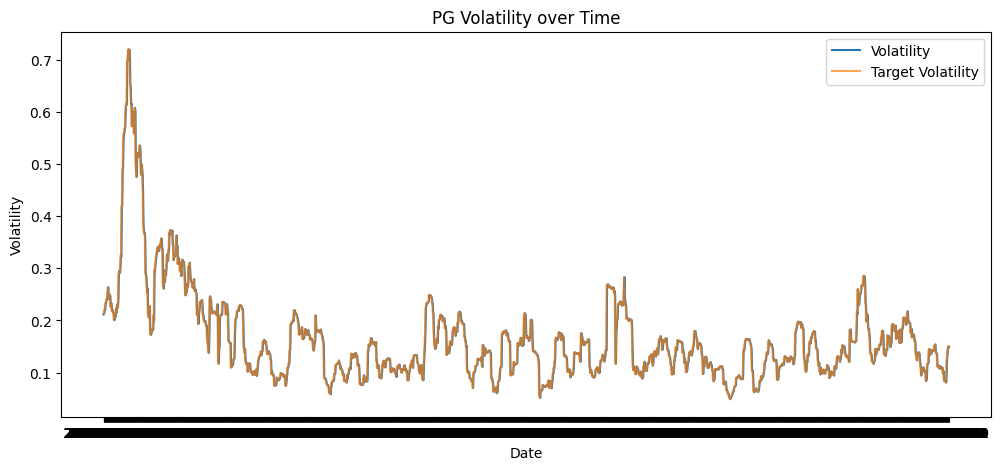

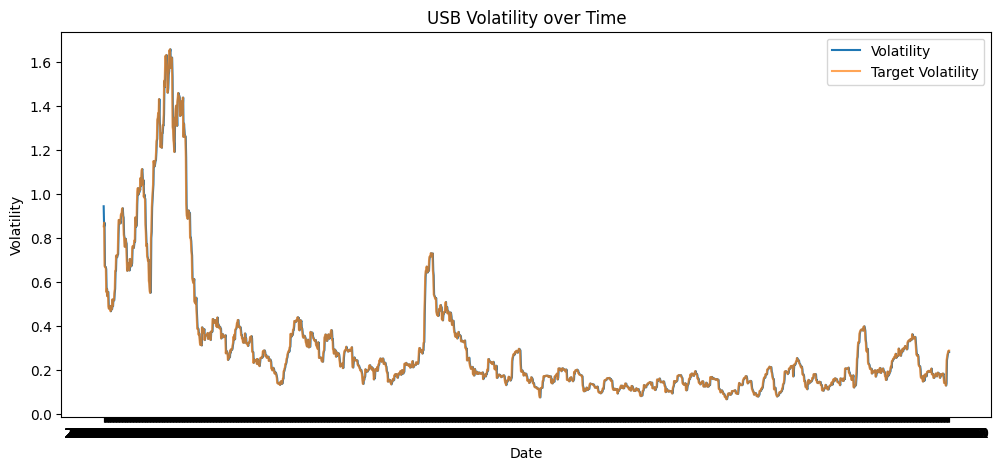

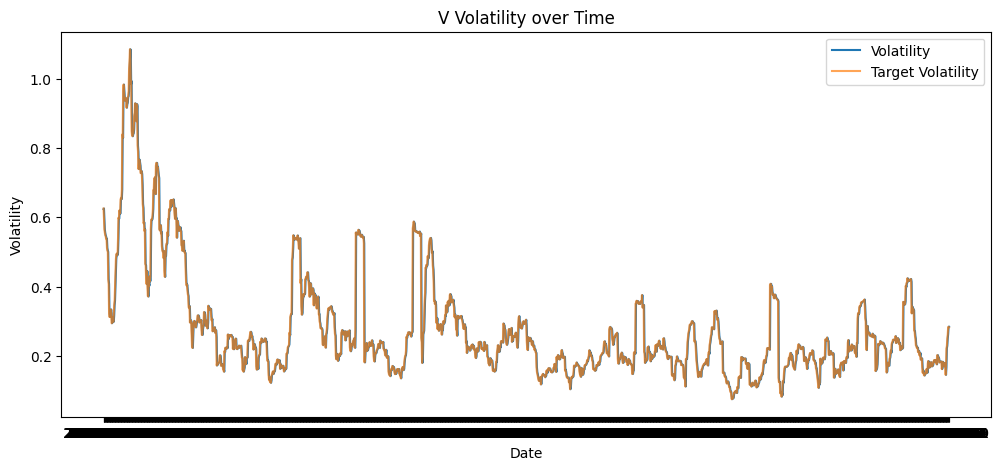

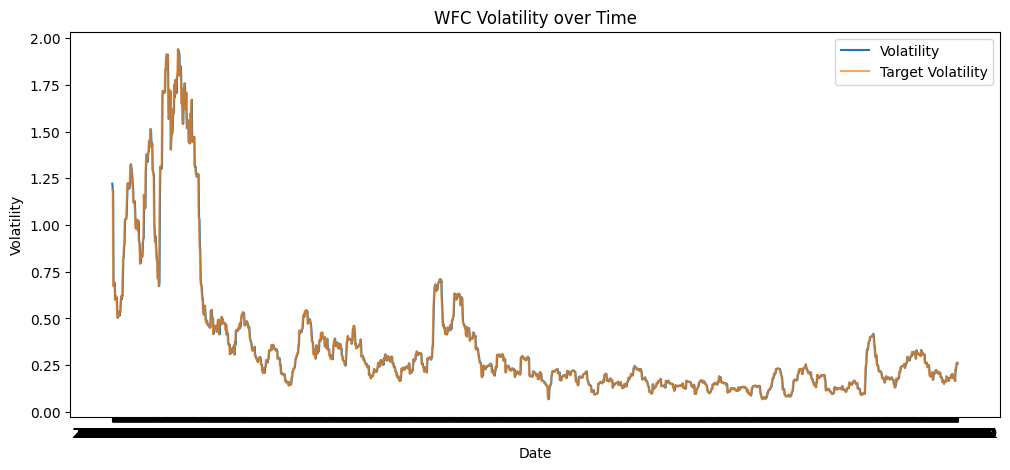

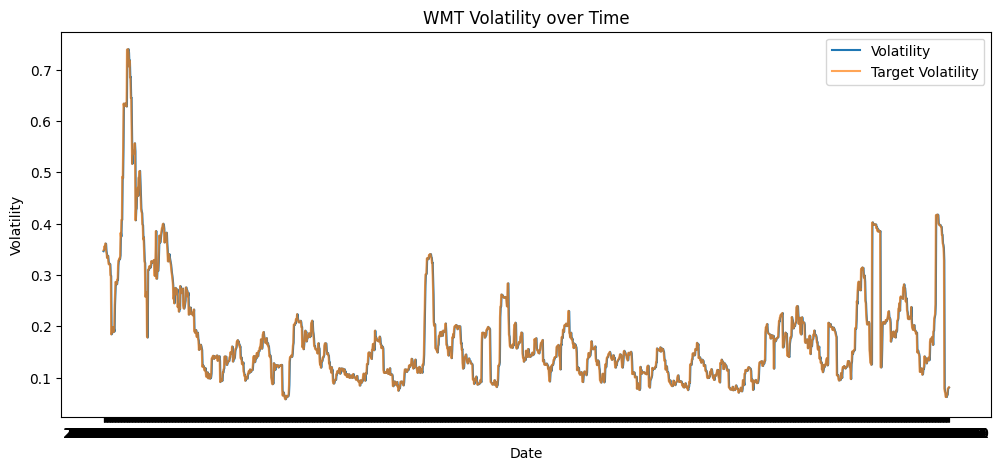

In [94]:
for t in df_final['Ticker'].unique():
    plt.figure(figsize=(12,5))
    plt.plot(df_final[df_final['Ticker']==t].index, 
             df_final[df_final['Ticker']==t]['Volatility'], label='Volatility')
    plt.plot(df_final[df_final['Ticker']==t].index, 
             df_final[df_final['Ticker']==t]['Target_Volatility'], label='Target Volatility', alpha=0.7)
    plt.title(f'{t} Volatility over Time')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

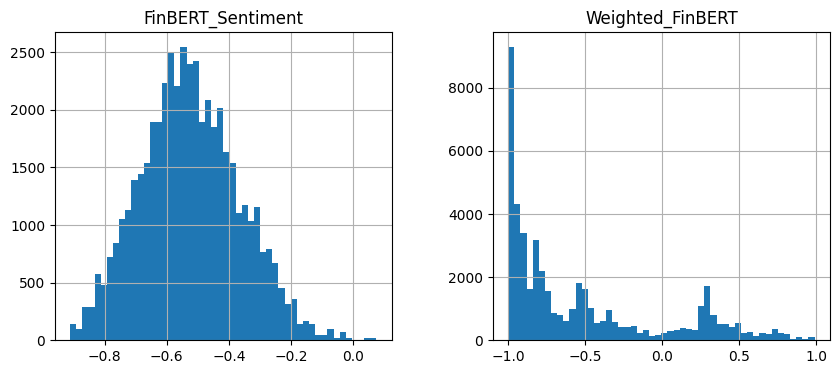

In [95]:
sentiment_cols = ['FinBERT_Sentiment', 'Weighted_FinBERT']
df_final[sentiment_cols].hist(bins=50, figsize=(10,4))
plt.show()

In [96]:
df_final.select_dtypes(include=['number']).corr()

Close      High       Low      Open    Volume  \
Close                     1.000000  0.999809  0.999819  0.999719 -0.283179   
High                      0.999809  1.000000  0.999613  0.999847 -0.282440   
Low                       0.999819  0.999613  1.000000  0.999775 -0.283779   
Open                      0.999719  0.999847  0.999775  1.000000 -0.282964   
Volume                   -0.283179 -0.282440 -0.283779 -0.282964  1.000000   
Daily_Return              0.005004 -0.002634 -0.001735 -0.008455  0.002359   
Log_Return                0.009660  0.001569  0.003217 -0.004001 -0.005884   
Volatility               -0.208488 -0.201344 -0.215244 -0.207632  0.197179   
Target_Label             -0.001464 -0.001083 -0.000719 -0.000710 -0.000533   
Target_Volatility        -0.208256 -0.200963 -0.215144 -0.207355  0.199823   
Close_Lag1                0.999558  0.999706  0.999627  0.999826 -0.282988   
Log_Return_Lag1           0.008826  0.008440  0.010938  0.009693 -0.016261   
Close_Lag2                0.999128  0.999301  0.999103  0.999356 -0.282704   
Log_Return_Lag2           0.008119  0.007079  0.008949  0.007824 -0.009998   
Close_Lag3                0.998726  0.998961  0.998664  0.998977 -0.282496   
Log_Return_Lag3           0.007771  0.006705  0.008292  0.007299 -0.013026   
Volatility_Lag3          -0.209224 -0.202626 -0.215359 -0.208417  0.184091   
Volatility_Lag5          -0.209863 -0.203460 -0.215837 -0.209119  0.182087   
Volatility_Lag10         -0.211532 -0.205387 -0.217114 -0.210637  0.177870   
SMA_5                     0.999495  0.999626  0.999438  0.999643 -0.282828   
SMA_10                    0.998930  0.999181  0.998803  0.999150 -0.282482   
SMA_ratio                 0.020998  0.018226  0.022449  0.019203 -0.024556   
Bollinger_Upper           0.994716  0.995701  0.993940  0.995096 -0.278492   
Bollinger_Lower           0.996890  0.996623  0.997256  0.997051 -0.284662   
Bollinger_Width           0.533963  0.542189  0.526537  0.535517 -0.115386   
RSI_14                    0.040642  0.035231  0.039503  0.033940 -0.024095   
FinBERT_Sentiment         0.012256  0.011734  0.012508  0.012181 -0.007385   
Weighted_FinBERT         -0.003816 -0.003577 -0.003979 -0.003604  0.004126   
Year                      0.311519  0.307768  0.315100  0.311123 -0.150845   
Month                    -0.010481 -0.009863 -0.010853 -0.010315 -0.005876   
DayOfWeek                -0.000870 -0.000868 -0.001148 -0.000973  0.010375   
TFIDF_PCA_0              -0.093684 -0.092572 -0.094595 -0.093425  0.043688   
TFIDF_PCA_1               0.012332  0.011906  0.012859  0.012367 -0.009865   
TFIDF_PCA_2               0.027419  0.027081  0.028119  0.027584 -0.015570   
TFIDF_PCA_3              -0.005157 -0.005598 -0.005042 -0.005393 -0.002767   
TFIDF_PCA_4              -0.068851 -0.068261 -0.069393 -0.068757  0.028767   
TFIDF_PCA_5              -0.059816 -0.059127 -0.060036 -0.059543  0.023687   
TFIDF_PCA_6               0.028031  0.028486  0.027652  0.028127 -0.008207   
TFIDF_PCA_7              -0.013425 -0.013202 -0.013489 -0.013301  0.007502   
TFIDF_PCA_8               0.025294  0.024300  0.026005  0.025160 -0.020994   
TFIDF_PCA_9               0.030437  0.030453  0.030558  0.030622 -0.014523   
FinBERT_Sentiment_Lag1    0.012429  0.011945  0.012996  0.012429 -0.009490   
FinBERT_Sentiment_Lag2    0.012923  0.012223  0.013150  0.012494 -0.011357   
FinBERT_Sentiment_Lag3    0.012679  0.012266  0.013308  0.012679 -0.009549   
Weighted_FinBERT_Lag1    -0.003558 -0.003347 -0.003739 -0.003528  0.003433   
Weighted_FinBERT_Lag2    -0.003364 -0.003357 -0.003637 -0.003372  0.004740   
Weighted_FinBERT_Lag3    -0.004005 -0.003585 -0.003968 -0.003579  0.004920   
FinBERT_Sentiment_Roll5   0.024070  0.023029  0.024826  0.023834 -0.018724   
FinBERT_Sentiment_Roll10  0.029767  0.028555  0.030997  0.029782 -0.024116   
Weighted_FinBERT_Roll5   -0.007935 -0.007748 -0.008478 -0.007953  0.009890   
Weighted_FinBERT_Roll10  -0.009832 -0.009693 -0.010

## *Granger Causality Test*

In [97]:
%%capture
from statsmodels.tsa.stattools import grangercausalitytests

targets = ['Target_Volatility', 'Target_Label']
features = [col for col in df_final.columns if col not in targets]
max_lag = 5

results = []

for target in targets:
    for feature in features:
        try:
            test_result = grangercausalitytests(df_final[[target, feature]], maxlag=max_lag)
            for lag in range(1, max_lag+1):
                p_value = test_result[lag][0]['ssr_ftest'][1]
                if p_value < 0.05:
                    results.append({
                        'Target': target,
                        'Feature': feature,
                        'Lag': lag,
                        'p_value': p_value
                    })
        except Exception as e:
            continue

causality_summary = pd.DataFrame(results)
causality_summary = causality_summary.sort_values(['Target', 'Feature', 'Lag']).reset_index(drop=True)
causality_summary

In [98]:
gc_df = causality_summary

not_relevant_features = (
    gc_df.groupby(['Target', 'Feature'])
    .filter(lambda x: (x['p_value'] >= 0.05).all())
    .drop_duplicates(subset=['Target', 'Feature'])
    [['Target', 'Feature']]
)

not_relevant_dict = (
    not_relevant_features.groupby('Target')['Feature']
    .apply(list)
    .to_dict()
)

print(not_relevant_dict)

{}


## *Feature Engineering*

In [5]:
cor_target = df_final.corr(numeric_only=True)['Target_Volatility'].drop(['Target_Volatility','Target_Label'])

low_corr_features = cor_target[(cor_target > -0.05) & (cor_target < 0.05)]

print("Features weakly correlated with 'Target_Volatility' (≈ 0):\n")
print(low_corr_features.sort_values())

Features weakly correlated with 'Target_Volatility' (≈ 0):

TFIDF_PCA_2               -0.045591
TFIDF_PCA_9               -0.026799
Log_Return_Lag3           -0.026789
Log_Return_Lag2           -0.021560
Log_Return_Lag1           -0.017889
TFIDF_PCA_3               -0.017420
TFIDF_PCA_1               -0.014423
Log_Return                -0.008647
Weighted_FinBERT_Lag3      0.000214
DayOfWeek                  0.000353
Weighted_FinBERT_Roll10    0.002055
Weighted_FinBERT_Lag1      0.002158
Weighted_FinBERT_Lag2      0.002175
Weighted_FinBERT           0.003065
Weighted_FinBERT_Roll5     0.004612
TFIDF_PCA_7                0.008113
Daily_Return               0.024573
TFIDF_PCA_6                0.036370
TFIDF_PCA_5                0.045967
TFIDF_PCA_4                0.047490
Name: Target_Volatility, dtype: float64


In [8]:
cols_to_drop = [
    'TFIDF_PCA_1',
    'TFIDF_PCA_3',
    'TFIDF_PCA_6',
    'TFIDF_PCA_7',
    'Log_Return',
    'Weighted_FinBERT_Roll5',
    'Weighted_FinBERT_Roll10',
    'Weighted_FinBERT_Lag1',
    'Weighted_FinBERT_Lag2',
    'Weighted_FinBERT_Lag3',
    'Target_Label'
]

df_final.drop(columns=cols_to_drop, inplace = True)

In [9]:
corr_matrix = df_final.select_dtypes(include=np.number).corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.90
high_corr = (
    upper.stack()
         .reset_index()
         .rename(columns={"level_0": "Feature1", "level_1": "Feature2", 0: "Correlation"})
)

high_corr = high_corr[(high_corr["Correlation"].abs() > threshold)].sort_values(by="Correlation", ascending=False)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

print(high_corr)

              Feature1           Feature2  Correlation
40                High               Open     0.999847
118               Open         Close_Lag1     0.999826
1                Close                Low     0.999819
351         Close_Lag2              SMA_5     0.999817
0                Close               High     0.999809
77                 Low               Open     0.999775
292         Close_Lag1              SMA_5     0.999737
406         Close_Lag3              SMA_5     0.999737
2                Close               Open     0.999719
45                High         Close_Lag1     0.999706
527              SMA_5             SMA_10     0.999683
127               Open              SMA_5     0.999643
82                 Low         Close_Lag1     0.999627
54                High              SMA_5     0.999626
39                High                Low     0.999613
7                Close         Close_Lag1     0.999558
346         Close_Lag2         Close_Lag3     0.999556
285       

In [9]:
columns_to_drop = [
    'Open',
    'High',
    'Low',
    'Close_Lag1',
    'Close_Lag2',
    'Close_Lag3',
    'SMA_5',
    'SMA_10',
    'Bollinger_Upper',
    'Bollinger_Lower',
    'Volatility'
]

df_final.drop(columns=columns_to_drop, axis=1, inplace=True)

In [10]:
df_final.shape

(47736, 30)

In [11]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47736 entries, 2008-08-08 to 2016-07-01
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Close                     47736 non-null  float64
 1   Volume                    47736 non-null  int64  
 2   Daily_Return              47736 non-null  float64
 3   Target_Volatility         47736 non-null  float64
 4   Log_Return_Lag1           47736 non-null  float64
 5   Log_Return_Lag2           47736 non-null  float64
 6   Log_Return_Lag3           47736 non-null  float64
 7   Volatility_Lag3           47736 non-null  float64
 8   Volatility_Lag5           47736 non-null  float64
 9   Volatility_Lag10          47736 non-null  float64
 10  SMA_ratio                 47736 non-null  float64
 11  Bollinger_Width           47736 non-null  float64
 12  RSI_14                    47736 non-null  float64
 13  Ticker                    47736 non-null  object 
 1

## *ML Models*

In [12]:
df_ml = pd.get_dummies(df_final, columns=['Ticker'], drop_first=True)

In [13]:
df_ml.shape

(47736, 52)

In [14]:
X = df_ml.drop(columns=['Target_Volatility'])
y = df_ml['Target_Volatility']

### Train-Test Split

In [15]:
X_train = df_ml.loc[df_ml.index <= '2014-12-31'].drop(columns=['Target_Volatility'])
y_train = df_ml.loc[df_ml.index <= '2014-12-31']['Target_Volatility']

X_test = df_ml.loc[df_ml.index >= '2015-01-02'].drop(columns=['Target_Volatility'])
y_test = df_ml.loc[df_ml.index >= '2015-01-02']['Target_Volatility']

In [16]:
tscv = TimeSeriesSplit(n_splits=5)

In [17]:
scoring = {
    'R2': 'r2',
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False),
    'MAE': 'neg_mean_absolute_error'
}

### XGBoost Regressor

In [111]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring=scoring,
    refit='R2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
cv_results = pd.DataFrame(grid_search.cv_results_)
best_idx = grid_search.best_index_
best_row = cv_results.iloc[best_idx]
print(f"CV R²: {best_row['mean_test_R2']:.4f}")
print(f"CV RMSE: {-best_row['mean_test_RMSE']:.4f}")
print(f"CV MAE: {-best_row['mean_test_MAE']:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
CV R²: 0.9179
CV RMSE: 0.0308
CV MAE: 0.0187


In [18]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {xgb_mae:.4f}")
print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost R² Score: {xgb_r2:.4f}")

XGBoost MAE: 0.0169
XGBoost RMSE: 0.0258
XGBoost R² Score: 0.9177


### LightGBM Regressor

In [ ]:
lgb_model = LGBMRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring=scoring,
    refit='R2',
    n_jobs=-1,
    verbose=-100
)

grid_search.fit(X_train, y_train)

In [115]:
print("Best parameters:", grid_search.best_params_)
cv_results = pd.DataFrame(grid_search.cv_results_)
best_idx = grid_search.best_index_
best_row = cv_results.iloc[best_idx]
print(f"CV R²: {best_row['mean_test_R2']:.4f}")
print(f"CV RMSE: {-best_row['mean_test_RMSE']:.4f}")
print(f"CV MAE: {-best_row['mean_test_MAE']:.4f}")

Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
CV R²: 0.9171
CV RMSE: 0.0307
CV MAE: 0.0190


In [19]:
lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=-1,
    objective='regression'
)

lgb.fit(X_train, y_train)

y_pred_lgb = lgb.predict(X_test)

lgb_mae = mean_absolute_error(y_test, y_pred_lgb)
lgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
lgb_r2 = r2_score(y_test, y_pred_lgb)

print(f"LGBoost MAE: {lgb_mae:.4f}")
print(f"LGBoost RMSE: {lgb_rmse:.4f}")
print(f"LGBoost R² Score: {lgb_r2:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6424
[LightGBM] [Info] Number of data points in the train set: 38664, number of used features: 51
[LightGBM] [Info] Start training from score 0.292546
LGBoost MAE: 0.0169
LGBoost RMSE: 0.0261
LGBoost R² Score: 0.9156


### CatBoost Regressor

In [117]:
cat_model = CatBoostRegressor(
    random_seed=42,
    silent=True
)

param_grid = {
    'iterations': [100, 200, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=tscv,
    scoring=scoring,
    refit='R2',  # optimize based on R²
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_idx = grid_search.best_index_
cv_results = grid_search.cv_results_
print(f"CV R²: {cv_results['mean_test_R2'][best_idx]:.4f}")
print(f"CV RMSE: {-cv_results['mean_test_RMSE'][best_idx]:.4f}")
print(f"CV MAE: {-cv_results['mean_test_MAE'][best_idx]:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
CV R²: 0.9159
CV RMSE: 0.0308
CV MAE: 0.0196


In [20]:
cat = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=1,
    random_seed=42,
    silent=True
)

cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)

cat_mae = mean_absolute_error(y_test, y_pred_cat)
cat_rmse = np.sqrt(mean_squared_error(y_test, y_pred_cat))
cat_r2 = r2_score(y_test, y_pred_cat)

print(f"CATBoost MAE: {cat_mae:.4f}")
print(f"CATBoost RMSE: {cat_rmse:.4f}")
print(f"CATBoost R² Score: {cat_r2:.4f}")

CATBoost MAE: 0.0171
CATBoost RMSE: 0.0263
CATBoost R² Score: 0.9143


## *DL Models*

In [21]:
TARGET_COL = "Target_Volatility"
TICKER_COL = "Ticker"
LOOKBACK = 30
HORIZON = 1
BATCH_SIZE = 256
EPOCHS = 200
SEED = 42

In [22]:
SCALER = RobustScaler()
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Scaling

In [23]:
df = df_final.copy()
df = df.sort_values([TICKER_COL, df.index.name])
feature_cols = [c for c in df.columns if c not in [TARGET_COL, TICKER_COL]]

def scale_group(g):
    g_feat = g[feature_cols]
    scaled = pd.DataFrame(
        SCALER.fit_transform(g_feat),
        index=g_feat.index,
        columns=g_feat.columns
    )
    g_scaled = g.copy()
    g_scaled[feature_cols] = scaled
    return g_scaled

df = df.groupby(TICKER_COL, group_keys=False).apply(scale_group)

In [24]:
le = LabelEncoder()
df[TICKER_COL] = le.fit_transform(df[TICKER_COL])
n_tickers = df[TICKER_COL].nunique()

### Train-Test-Validation Split

In [25]:
dates = df.index.unique().sort_values()
n = len(dates)
train_end = dates[int(n*0.7)]
val_end   = dates[int(n*0.85)]

def split_by_date(g):
    return (
        g.loc[g.index <= train_end],
        g.loc[(g.index > train_end) & (g.index <= val_end)],
        g.loc[g.index > val_end]
    )

groups = dict(tuple(df.groupby(TICKER_COL)))
train_parts, val_parts, test_parts = [], [], []
for tkr, g in groups.items():
    tr, va, te = split_by_date(g)
    train_parts.append(tr)
    val_parts.append(va)
    test_parts.append(te)

df_train = pd.concat(train_parts).sort_values([TICKER_COL, df.index.name])
df_val   = pd.concat(val_parts).sort_values([TICKER_COL, df.index.name])
df_test  = pd.concat(test_parts).sort_values([TICKER_COL, df.index.name])

### Building Sequences

In [26]:
def make_sequences(g, lookback=LOOKBACK):
    X_list, y_list, t_list = [], [], []
    feat = g[feature_cols].values
    y = g[TARGET_COL].values
    t = g[TICKER_COL].values
    for i in range(lookback-1, len(g)):
        X_list.append(feat[i-lookback+1:i+1])
        y_list.append(y[i])
        t_list.append(t[i])  # ticker ID at prediction time
    if not X_list:
        return None, None, None
    return np.stack(X_list), np.array(y_list), np.array(t_list)

def stack_sequences(df_part):
    Xs, ys, ts = [], [], []
    for _, g in df_part.groupby(TICKER_COL):
        Xg, yg, tg = make_sequences(g)
        if Xg is not None:
            Xs.append(Xg); ys.append(yg); ts.append(tg)
    if not Xs:
        return None, None, None
    return np.vstack(Xs), np.concatenate(ys), np.concatenate(ts)

X_train, y_train, t_train = stack_sequences(df_train)
X_val,   y_val,   t_val   = stack_sequences(df_val)
X_test,  y_test,  t_test  = stack_sequences(df_test)

print("Shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

Shapes: (32736, 30, 28) (32736,) (6456, 30, 28) (6456,) (6456, 30, 28) (6456,)


In [27]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train, t_train), y_train)) \
    .shuffle(8192).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices(((X_val, t_val), y_val)) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices(((X_test, t_test), y_test)) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1758449926.496897      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758449926.497559      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### *GRU* - Gated Recurrent Unit

In [36]:
def build_model(n_features, n_tickers, emb_dim=8):
    
    price_inp = tf.keras.Input(shape=(LOOKBACK, n_features), name="price_inp")
    x = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(price_inp)
    x = tf.keras.layers.GRU(32, dropout=0.2)(x)

    tkr_inp = tf.keras.Input(shape=(), dtype=tf.int32, name="tkr_inp")
    tkr_emb = tf.keras.layers.Embedding(input_dim=n_tickers, output_dim=emb_dim)(tkr_inp)
    tkr_emb = tf.keras.layers.Flatten()(tkr_emb)

    concat = tf.keras.layers.Concatenate()([x, tkr_emb])
    dense = tf.keras.layers.Dense(64, activation='relu')(concat)
    dense = tf.keras.layers.Dropout(0.2)(dense)
    out = tf.keras.layers.Dense(1, activation = 'linear')(dense)

    model = tf.keras.Model(inputs=[price_inp, tkr_inp], outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.Huber(delta=0.01),
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

gru = build_model(n_features=len(feature_cols), n_tickers=n_tickers)
gru.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5, verbose=1)
]

history = gru.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

y_pred_gru = gru.predict(test_ds).reshape(-1)
gru_mae = mean_absolute_error(y_test, y_pred_gru)
gru_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gru))
gru_r2 = r2_score(y_test, y_pred_gru)
print(f"GRU+TickerEmbedding -> MAE: {gru_mae:.4f}  RMSE: {gru_rmse:.4f}  R²: {gru_r2:.4f}")

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ price_inp           │ (None, 30, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tkr_inp             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 30, 64)    │     18,048 │ price_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 8)         │        192 │ tkr_inp[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 32)        │      9,408 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 8)         │          0 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 40)        │          0 │ gru_15[0][0],     │
│ (Concatenate)       │                   │            │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      2,624 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │         65 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,337 (118.50 KB)

 Trainable params: 30,337 (118.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0018 - mae: 0.1818 - val_loss: 4.9999e-04 - val_mae: 0.0548 - learning_rate: 0.0010
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.8890e-04 - mae: 0.0737 - val_loss: 3.5262e-04 - val_mae: 0.0400 - learning_rate: 0.0010
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5081e-04 - mae: 0.0598 - val_loss: 3.1062e-04 - val_mae: 0.0357 - learning_rate: 0.0010
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9066e-04 - mae: 0.0538 - val_loss: 2.7354e-04 - val_mae: 0.0320 - learning_rate: 0.0010
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5641e-04 - mae: 0.0503 - val_loss: 2.5901e-04 - val_mae: 0.0305 - learning_rate: 0.0010
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.1419e-04 - mae: 0.0461 - val_loss: 2.3695e-04 - val_mae: 0.0283 - learning_rate: 0.0010
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9666e-04 - mae: 0.0443 - val_loss:

### *Stacked GRU*

In [30]:
def build_model(n_features, n_tickers, emb_dim=8):
    
    price_inp = tf.keras.Input(shape=(LOOKBACK, n_features), name="price_inp")
    x = tf.keras.layers.GRU(128, return_sequences=True, dropout=0.2)(price_inp)
    x = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2)(x)
    x = tf.keras.layers.GRU(32, dropout=0.2)(x)

    tkr_inp = tf.keras.Input(shape=(), dtype=tf.int32, name="tkr_inp")
    tkr_emb = tf.keras.layers.Embedding(input_dim=n_tickers, output_dim=emb_dim)(tkr_inp)
    tkr_emb = tf.keras.layers.Flatten()(tkr_emb)

    concat = tf.keras.layers.Concatenate()([x, tkr_emb])
    dense = tf.keras.layers.Dense(128, activation='relu')(concat)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    dense = tf.keras.layers.Dense(64, activation='relu')(dense)
    dense = tf.keras.layers.Dropout(0.2)(dense)
    out = tf.keras.layers.Dense(1, activation='linear')(dense)

    model = tf.keras.Model(inputs=[price_inp, tkr_inp], outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.Huber(delta=0.01),
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

stackedgru = build_model(n_features=len(feature_cols), n_tickers=n_tickers)
stackedgru.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5, verbose=1)
]

history = stackedgru.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

y_pred_stackedgru = stackedgru.predict(test_ds).reshape(-1)
stackedgru_mae = mean_absolute_error(y_test, y_pred_stackedgru)
stackedgru_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stackedgru))
stackedgru_r2 = r2_score(y_test, y_pred_stackedgru)
print(f"Stacked GRU+TickerEmbedding -> MAE: {stackedgru_mae:.4f}  RMSE: {stackedgru_rmse:.4f}  R²: {stackedgru_r2:.4f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ price_inp           │ (None, 30, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 30, 128)   │     60,672 │ price_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tkr_inp             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 30, 64)    │     37,248 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 8)         │        192 │ tkr_inp[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 32)        │      9,408 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 8)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 40)        │          0 │ gru_7[0][0],      │
│ (Concatenate)       │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │      5,248 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 121,089 (473.00 KB)

 Trainable params: 121,089 (473.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0013 - mae: 0.1369 - val_loss: 3.6618e-04 - val_mae: 0.0413 - learning_rate: 0.0010
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.5544e-04 - mae: 0.0703 - val_loss: 2.9559e-04 - val_mae: 0.0342 - learning_rate: 0.0010
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.4500e-04 - mae: 0.0592 - val_loss: 2.6080e-04 - val_mae: 0.0307 - learning_rate: 0.0010
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.7386e-04 - mae: 0.0521 - val_loss: 2.4496e-04 - val_mae: 0.0291 - learning_rate: 0.0010
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.4914e-04 - mae: 0.0496 - val_loss: 2.2623e-04 - val_mae: 0.0272 - learning_rate: 0.0010
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.2341e-04 - mae: 0.0470 - val_loss: 2.2401e-04 - val_mae: 0.0270 - learning_rate: 0.0010
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.9803e-04 - mae: 0.0444 - val

### *Stacked LSTM* - Long Short Term Memory

In [40]:
def build_model(n_features, n_tickers, emb_dim=8):
    
    price_inp = tf.keras.Input(shape=(LOOKBACK, n_features), name="price_inp")
    x = tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2)(price_inp)
    x = tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2)(x)
    x = tf.keras.layers.LSTM(32, dropout=0.2)(x)

    tkr_inp = tf.keras.Input(shape=(), dtype=tf.int32, name="tkr_inp")
    tkr_emb = tf.keras.layers.Embedding(input_dim=n_tickers, output_dim=emb_dim)(tkr_inp)
    tkr_emb = tf.keras.layers.Flatten()(tkr_emb)

    concat = tf.keras.layers.Concatenate()([x, tkr_emb])
    dense = tf.keras.layers.Dense(128, activation='relu')(concat)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    dense = tf.keras.layers.Dense(64, activation='relu')(dense)
    dense = tf.keras.layers.Dropout(0.2)(dense)
    out = tf.keras.layers.Dense(1, activation='linear')(dense)

    model = tf.keras.Model(inputs=[price_inp, tkr_inp], outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.Huber(delta=0.01),
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

stackedlstm = build_model(n_features=len(feature_cols), n_tickers=n_tickers)
stackedlstm.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5, verbose=1)
]

history = stackedlstm.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

y_pred_stackedlstm = stackedlstm.predict(test_ds).reshape(-1)
stackedlstm_mae = mean_absolute_error(y_test, y_pred_stackedlstm)
stackedlstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stackedlstm))
stackedlstm_r2 = r2_score(y_test, y_pred_stackedlstm)
print(f"Stacked LSTM+TickerEmbedding -> MAE: {stackedlstm_mae:.4f}  RMSE: {stackedlstm_rmse:.4f}  R²: {stackedlstm_r2:.4f}")

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ price_inp           │ (None, 30, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 30, 128)   │     80,384 │ price_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tkr_inp             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 30, 64)    │     49,408 │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 8)         │        192 │ tkr_inp[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 32)        │     12,416 │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 8)         │          0 │ embedding_12[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 40)        │          0 │ lstm_17[0][0],    │
│ (Concatenate)       │                   │            │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 128)       │      5,248 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 64)        │      8,256 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64)        │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1)         │         65 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 155,969 (609.25 KB)

 Trainable params: 155,969 (609.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0015 - mae: 0.1552 - val_loss: 3.8772e-04 - val_mae: 0.0435 - learning_rate: 0.0010
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.8438e-04 - mae: 0.0632 - val_loss: 3.0027e-04 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.1927e-04 - mae: 0.0566 - val_loss: 2.5748e-04 - val_mae: 0.0304 - learning_rate: 0.0010
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.6557e-04 - mae: 0.0512 - val_loss: 2.3958e-04 - val_mae: 0.0285 - learning_rate: 0.0010
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.2108e-04 - mae: 0.0468 - val_loss: 2.2210e-04 - val_mae: 0.0268 - learning_rate: 0.0010
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.0346e-04 - mae: 0.0450 - val_loss: 2.0692e-04 - val_mae: 0.0252 - learning_rate: 0.0010
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.7791e-04 - mae: 0.0424 - val

### Attention Block

In [41]:
class TimeAttention(Layer):
    def __init__(self, units=32, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.W = tf.keras.layers.Dense(units, activation='tanh')
        self.v = tf.keras.layers.Dense(1, use_bias=False)

    def call(self, inputs, mask=None):
        u = self.W(inputs)
        scores = self.v(u)
        scores = tf.squeeze(scores, axis=-1)
        if mask is not None:
            scores += (1.0 - tf.cast(mask, tf.float32)) * -1e9
        attn = tf.nn.softmax(scores, axis=-1)
        context = tf.matmul(tf.expand_dims(attn, 1), inputs)
        return tf.squeeze(context, axis=1)

class MeanLayer(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)

class StdPooling1D(Layer):
    def call(self, inputs):
        return tf.math.reduce_std(inputs, axis=1)

### *Stacked GRU with Attention*

In [43]:
def build_model(n_features, n_tickers, emb_dim=8, gru_units1=128, gru_units2=64):
    price_inp = tf.keras.Input(shape=(LOOKBACK, n_features), name="price_inp")
    x = tf.keras.layers.GRU(gru_units1, return_sequences=True, dropout=0.15)(price_inp)
    x = tf.keras.layers.GRU(gru_units2, return_sequences=True, dropout=0.12)(x)
    x = tf.keras.layers.LayerNormalization()(x)

    context = TimeAttention(units=64)(x)

    tkr_inp = tf.keras.Input(shape=(), dtype=tf.int32, name="tkr_inp")
    tkr_emb = tf.keras.layers.Embedding(input_dim=n_tickers, output_dim=emb_dim,
                                        embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(tkr_inp)
    tkr_emb = tf.keras.layers.Flatten()(tkr_emb)

    last_mean = MeanLayer()(x)
    last_std  = StdPooling1D()(x)
    concat = tf.keras.layers.Concatenate()([context, last_mean, last_std, tkr_emb])

    d = tf.keras.layers.Dense(128, activation='swish',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-6))(concat)
    d = tf.keras.layers.Dropout(0.25)(d)
    d = tf.keras.layers.Dense(64, activation='swish',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-6))(d)
    d = tf.keras.layers.Dropout(0.2)(d)
    out = tf.keras.layers.Dense(1, activation='linear', name='out')(d)

    model = tf.keras.Model(inputs=[price_inp, tkr_inp], outputs=out)

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.Huber(delta=0.01),
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

attentiongru = build_model(len(feature_cols), n_tickers)
attentiongru.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6, verbose=1)
]

history = attentiongru.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

y_pred_attentiongru = attentiongru.predict(test_ds).reshape(-1)
attentiongru_mae = mean_absolute_error(y_test, y_pred_attentiongru)
attentiongru_rmse = np.sqrt(mean_squared_error(y_test, y_pred_attentiongru))
attentiongru_r2 = r2_score(y_test, y_pred_attentiongru)
print(f"Improved GRU+Attn+Ticker -> MAE: {attentiongru_mae:.4f}  RMSE: {attentiongru_rmse:.4f}  R²: {attentiongru_r2:.4f}")

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ price_inp           │ (None, 30, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 30, 128)   │     60,672 │ price_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 30, 64)    │     37,248 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tkr_inp             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ gru_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 8)         │        192 │ tkr_inp[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_attention_1    │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (TimeAttention)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_layer_1        │ (None, 64)        │          0 │ layer_normalizat… │
│ (MeanLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ std_pooling1d_1     │ (None, 64)        │          0 │ layer_normalizat… │
│ (StdPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 8)         │          0 │ embedding_14[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 200)       │          0 │ time_attention_1… │
│ (Concatenate)       │                   │            │ mean_layer_1[0][… │
│                     │                   │            │ std_pooling1d_1[… │
│                     │                   │            │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 128)       │     25,728 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 128)       │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │      8,256 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 64)        │          0 │ dense_41[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         65 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 136,513 (533.25 KB)

 Trainable params: 136,513 (533.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0021 - mae: 0.1948 - val_loss: 7.6198e-04 - val_mae: 0.0583 - learning_rate: 0.0010
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0012 - mae: 0.0988 - val_loss: 6.6564e-04 - val_mae: 0.0496 - learning_rate: 0.0010
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 9.0633e-04 - mae: 0.0740 - val_loss: 5.4129e-04 - val_mae: 0.0383 - learning_rate: 0.0010
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7.9794e-04 - mae: 0.0643 - val_loss: 5.5078e-04 - val_mae: 0.0404 - learning_rate: 0.0010
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.7153e-04 - mae: 0.0528 - val_loss: 4.4534e-04 - val_mae: 0.0308 - learning_rate: 0.0010
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.1537e-04 - mae: 0.0482 - val_loss: 4.3709e-04 - val_mae: 0.0310 - learning_rate: 0.0010
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.7691e-04 - mae: 0.0453 - val_los

### *Stacked LSTM with Attention*

In [45]:
def build_model(n_features, n_tickers, emb_dim=8, lstm_units1=128, lstm_units2=64):
    price_inp = tf.keras.Input(shape=(LOOKBACK, n_features), name="price_inp")
    x = tf.keras.layers.LSTM(lstm_units1, return_sequences=True, dropout=0.15)(price_inp)
    x = tf.keras.layers.LSTM(lstm_units2, return_sequences=True, dropout=0.12)(x)
    x = tf.keras.layers.LayerNormalization()(x)

    context = TimeAttention(units=64)(x)

    tkr_inp = tf.keras.Input(shape=(), dtype=tf.int32, name="tkr_inp")
    tkr_emb = tf.keras.layers.Embedding(input_dim=n_tickers, output_dim=emb_dim)(tkr_inp)
    tkr_emb = tf.keras.layers.Flatten()(tkr_emb)

    last_mean = tf.keras.layers.GlobalAveragePooling1D()(x)
    last_std = StdPooling1D()(x)

    concat = tf.keras.layers.Concatenate()([context, last_mean, last_std, tkr_emb])
    d = tf.keras.layers.Dense(128, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(concat)
    d = tf.keras.layers.Dropout(0.25)(d)
    d = tf.keras.layers.Dense(64, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(d)
    d = tf.keras.layers.Dropout(0.2)(d)
    out = tf.keras.layers.Dense(1, activation='linear', name='out')(d)

    model = tf.keras.Model(inputs=[price_inp, tkr_inp], outputs=out)

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(optimizer=opt, loss=tf.keras.losses.Huber(delta=0.01),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])
    return model

attentionlstm = build_model(len(feature_cols), n_tickers)
attentionlstm.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6, verbose=1)
]

history = attentionlstm.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)

y_pred_attentionlstm = attentionlstm.predict(test_ds).reshape(-1)
attentionlstm_mae = mean_absolute_error(y_test, y_pred_attentionlstm)
attentionlstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_attentionlstm))
attentionlstm_r2 = r2_score(y_test, y_pred_attentionlstm)
print(f"Improved LSTM+Attn+Ticker -> MAE: {attentionlstm_mae:.4f}  RMSE: {attentionlstm_rmse:.4f}  R²: {attentionlstm_r2:.4f}")

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ price_inp           │ (None, 30, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 30, 128)   │     80,384 │ price_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 30, 64)    │     49,408 │ lstm_20[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tkr_inp             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ lstm_21[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, 8)         │        192 │ tkr_inp[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_attention_3    │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (TimeAttention)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ std_pooling1d_3     │ (None, 64)        │          0 │ layer_normalizat… │
│ (StdPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 8)         │          0 │ embedding_16[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 200)       │          0 │ time_attention_3… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ std_pooling1d_3[… │
│                     │                   │            │ flatten_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 128)       │     25,728 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 128)       │          0 │ dense_48[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 64)        │      8,256 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64)        │          0 │ dense_49[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         65 │ dropout_28[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 168,385 (657.75 KB)

 Trainable params: 168,385 (657.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0023 - mae: 0.2080 - val_loss: 8.0941e-04 - val_mae: 0.0630 - learning_rate: 0.0010
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0011 - mae: 0.0895 - val_loss: 6.4506e-04 - val_mae: 0.0477 - learning_rate: 0.0010
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8.6908e-04 - mae: 0.0705 - val_loss: 6.0045e-04 - val_mae: 0.0444 - learning_rate: 0.0010
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7.4142e-04 - mae: 0.0588 - val_loss: 5.1668e-04 - val_mae: 0.0371 - learning_rate: 0.0010
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.6946e-04 - mae: 0.0527 - val_loss: 5.3643e-04 - val_mae: 0.0402 - learning_rate: 0.0010
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.1408e-04 - mae: 0.0483 - val_loss: 4.0074e-04 - val_mae: 0.0276 - learning_rate: 0.0010
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.7003e-04 - mae: 0.0449 - val_los

### *Multimodal DL with Attention*

In [46]:
price_cols = ['Close','Volume','Daily_Return','Log_Return_Lag1','Log_Return_Lag2',
              'Log_Return_Lag3','Volatility_Lag3','SMA_ratio','RSI_14',
              'Bollinger_Width','Volatility_Lag5','Volatility_Lag10']

news_cols = ['FinBERT_Sentiment','Weighted_FinBERT','FinBERT_Sentiment_Lag1',
             'FinBERT_Sentiment_Lag2','FinBERT_Sentiment_Lag3',
             'FinBERT_Sentiment_Roll5','FinBERT_Sentiment_Roll10',
             'TFIDF_PCA_0','TFIDF_PCA_2','TFIDF_PCA_4',
             'TFIDF_PCA_5','TFIDF_PCA_8','TFIDF_PCA_9']

feature_cols = price_cols + news_cols

In [47]:
df = df_final.copy()
df = df.sort_values([TICKER_COL, df.index.name])

scaler_price = RobustScaler()
scaler_news  = RobustScaler()

def scale_group(g):
    g_price = g[price_cols]
    g_news  = g[news_cols]
    g_scaled = g.copy()
    g_scaled[price_cols] = scaler_price.fit_transform(g_price)
    g_scaled[news_cols]  = scaler_news.fit_transform(g_news)
    return g_scaled

df = df.groupby(TICKER_COL, group_keys=False).apply(scale_group)

In [48]:
le = LabelEncoder()
df[TICKER_COL] = le.fit_transform(df[TICKER_COL])
n_tickers = df[TICKER_COL].nunique()

In [49]:
dates = df.index.unique().sort_values()
train_end = dates[int(len(dates)*0.7)]
val_end   = dates[int(len(dates)*0.85)]

In [50]:
def split_by_date(g):
    return (
        g.loc[g.index <= train_end],
        g.loc[(g.index > train_end) & (g.index <= val_end)],
        g.loc[g.index > val_end]
    )

train_parts, val_parts, test_parts = [], [], []
for _, g in df.groupby(TICKER_COL):
    tr, va, te = split_by_date(g)
    train_parts.append(tr)
    val_parts.append(va)
    test_parts.append(te)

df_train = pd.concat(train_parts).sort_values([TICKER_COL, df.index.name])
df_val   = pd.concat(val_parts).sort_values([TICKER_COL, df.index.name])
df_test  = pd.concat(test_parts).sort_values([TICKER_COL, df.index.name])

In [51]:
def make_sequences(g, lookback=LOOKBACK):
    X_price_list, X_news_list, y_list, t_list = [], [], [], []
    feat_price = g[price_cols].values
    feat_news  = g[news_cols].values
    y = g[TARGET_COL].values
    t = g[TICKER_COL].values
    for i in range(lookback-1, len(g)):
        X_price_list.append(feat_price[i-lookback+1:i+1])
        X_news_list.append(feat_news[i-lookback+1:i+1])
        y_list.append(y[i])
        t_list.append(t[i])
    if not X_price_list:
        return None, None, None, None
    return (np.stack(X_price_list), np.stack(X_news_list),
            np.array(y_list), np.array(t_list))

def stack_sequences(df_part):
    X_price_all, X_news_all, y_all, t_all = [], [], [], []
    for _, g in df_part.groupby(TICKER_COL):
        Xp, Xn, y, t = make_sequences(g)
        if Xp is not None:
            X_price_all.append(Xp)
            X_news_all.append(Xn)
            y_all.append(y)
            t_all.append(t)
    if not X_price_all:
        return None, None, None, None
    return (np.vstack(X_price_all), np.vstack(X_news_all),
            np.concatenate(y_all), np.concatenate(t_all))

X_price_train, X_news_train, y_train, t_train = stack_sequences(df_train)
X_price_val,   X_news_val,   y_val,   t_val   = stack_sequences(df_val)
X_price_test,  X_news_test,  y_test,  t_test  = stack_sequences(df_test)

print("Shapes:", X_price_train.shape, X_news_train.shape, y_train.shape, t_train.shape)

Shapes: (32736, 30, 12) (32736, 30, 13) (32736,) (32736,)


In [52]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_price_train, X_news_train, t_train), y_train)) \
    .shuffle(8192, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(((X_price_val, X_news_val, t_val), y_val)) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(((X_price_test, X_news_test, t_test), y_test)) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [59]:
def build_multimodal_lstm(n_price, n_news, n_tickers, emb_dim=8, lstm_units1=128, lstm_units2=64):
    
    price_inp = tf.keras.Input(shape=(LOOKBACK, n_price), name="price_inp")
    x1 = tf.keras.layers.LSTM(lstm_units1, return_sequences=True, dropout=0.15)(price_inp)
    x1 = tf.keras.layers.LSTM(lstm_units2, return_sequences=True, dropout=0.12)(x1)
    x1 = tf.keras.layers.LayerNormalization()(x1)
    context_price = TimeAttention(64)(x1)
    mean_price = tf.keras.layers.GlobalAveragePooling1D()(x1)
    std_price  = StdPooling1D()(x1)

    news_inp = tf.keras.Input(shape=(LOOKBACK, n_news), name="news_inp")
    x2 = tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.15)(news_inp)
    x2 = tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.12)(x2)
    x2 = tf.keras.layers.LayerNormalization()(x2)
    context_news = TimeAttention(32)(x2)
    mean_news = tf.keras.layers.GlobalAveragePooling1D()(x2)
    std_news  = StdPooling1D()(x2)

    tkr_inp = tf.keras.Input(shape=(), dtype=tf.int32, name="tkr_inp")
    tkr_emb = tf.keras.layers.Embedding(input_dim=n_tickers, output_dim=emb_dim)(tkr_inp)
    tkr_emb = tf.keras.layers.Flatten()(tkr_emb)

    concat = tf.keras.layers.Concatenate()([context_price, mean_price, std_price,
                                            context_news, mean_news, std_news, tkr_emb])
    d = tf.keras.layers.Dense(128, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(concat)
    d = tf.keras.layers.Dropout(0.25)(d)
    d = tf.keras.layers.Dense(64, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(d)
    d = tf.keras.layers.Dropout(0.2)(d)
    out = tf.keras.layers.Dense(1, activation='linear', name='out')(d)

    model = tf.keras.Model(inputs=[price_inp, news_inp, tkr_inp], outputs=out)

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss=tf.keras.losses.Huber(delta=0.01),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])
    return model

multimodal = build_multimodal_lstm(len(price_cols), len(news_cols), n_tickers)
multimodal.summary()

ckpt_path = "best_multimodal_lstm.keras"
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6, verbose=1)
]

history = multimodal.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)

y_pred_multimodal = multimodal.predict(test_ds).reshape(-1)
multimodal_mae = mean_absolute_error(y_test, y_pred_multimodal)
multimodal_rmse = np.sqrt(mean_squared_error(y_test, y_pred_multimodal))
multimodal_r2 = r2_score(y_test, y_pred_multimodal)
print(f"Multimodal Stacked LSTM+Attn+Ticker -> MAE: {multimodal_mae:.4f}  RMSE: {multimodal_rmse:.4f}  R²: {multimodal_r2:.4f}")

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ price_inp           │ (None, 30, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ news_inp            │ (None, 30, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_46 (LSTM)      │ (None, 30, 128)   │     72,192 │ price_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_48 (LSTM)      │ (None, 30, 64)    │     19,968 │ news_inp[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_47 (LSTM)      │ (None, 30, 64)    │     49,408 │ lstm_46[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_49 (LSTM)      │ (None, 30, 32)    │     12,416 │ lstm_48[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tkr_inp             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ lstm_47[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 32)    │         64 │ lstm_49[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_23        │ (None, 8)         │        192 │ tkr_inp[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_attention_16   │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (TimeAttention)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ std_pooling1d_16    │ (None, 64)        │          0 │ layer_normalizat… │
│ (StdPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_attention_17   │ (None, 32)        │      1,088 │ layer_normalizat… │
│ (TimeAttention)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ std_pooling1d_17    │ (None, 32)        │          0 │ layer_normalizat… │
│ (StdPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_23          │ (None, 8)         │          0 │ embedding_23[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_23      │ (None, 296)       │          0 │ time_attention_1… │
│ (Concatenate)       │                   │            │ global_average_p

 Total params: 206,017 (804.75 KB)

 Trainable params: 206,017 (804.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0023 - mae: 0.2040 - val_loss: 7.4761e-04 - val_mae: 0.0544 - learning_rate: 0.0010
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0012 - mae: 0.0956 - val_loss: 6.3873e-04 - val_mae: 0.0449 - learning_rate: 0.0010
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.2731e-04 - mae: 0.0741 - val_loss: 5.2350e-04 - val_mae: 0.0346 - learning_rate: 0.0010
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.9803e-04 - mae: 0.0625 - val_loss: 4.9895e-04 - val_mae: 0.0335 - learning_rate: 0.0010
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.0517e-04 - mae: 0.0545 - val_loss: 3.9563e-04 - val_mae: 0.0244 - learning_rate: 0.0010
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.4990e-04 - mae: 0.0503 - val_loss: 3.5979e-04 - val_mae: 0.0220 - learning_rate: 0.0010
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.8318e-04 - mae: 0.0448 - val_lo

## *Backtesting*

In [60]:
def evaluate_regime_multimodal(model, X_price, X_news, tkr, y, regime="low"):
    
    low_thr = np.percentile(y, 33)
    high_thr = np.percentile(y, 66)

    if regime == "low":
        mask = y <= low_thr
    elif regime == "mid":
        mask = (y > low_thr) & (y <= high_thr)
    elif regime == "high":
        mask = y > high_thr
    else:
        raise ValueError("regime must be 'low', 'mid', or 'high'")

    if mask.sum() == 0:
        print(f"No samples for {regime} regime.")
        return None

    X_price_masked = X_price[mask]
    X_news_masked  = X_news[mask]
    tkr_masked     = tkr[mask]
    y_masked       = y[mask]

    y_pred = model.predict((X_price_masked, X_news_masked, tkr_masked), verbose=0).reshape(-1)

    mae  = mean_absolute_error(y_masked, y_pred)
    rmse = mean_squared_error(y_masked, y_pred, squared=False)
    r2   = r2_score(y_masked, y_pred)
    print(f"{regime.capitalize()} volatility regime -> Samples: {len(y_masked)} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")
    return mae, rmse, r2

evaluate_regime_multimodal(multimodal, X_price_test, X_news_test, t_test, y_test, "low")
evaluate_regime_multimodal(multimodal, X_price_test, X_news_test, t_test, y_test, "mid")
evaluate_regime_multimodal(multimodal, X_price_test, X_news_test, t_test, y_test, "high")

Low volatility regime -> Samples: 2131 | MAE: 0.0089 | RMSE: 0.0128 | R²: 0.7114
Mid volatility regime -> Samples: 2130 | MAE: 0.0117 | RMSE: 0.0170 | R²: 0.5076
High volatility regime -> Samples: 2195 | MAE: 0.0186 | RMSE: 0.0311 | R²: 0.8345


(0.018606731837951026, 0.031137767437841198, 0.834457260669894)

In [61]:
def performance_metrics(returns, positions=None):
    returns = pd.Series(returns)
    cum_returns = (1 + returns).cumprod() - 1

    cagr = (1 + cum_returns.iloc[-1]) ** (252 / len(returns)) - 1
    sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else np.nan
    maxdd = (cum_returns.cummax() - cum_returns).max()

    wins = returns[returns > 0]
    losses = returns[returns < 0]
    hit_rate = len(wins) / len(returns)
    avg_win = wins.mean() if len(wins) > 0 else np.nan
    avg_loss = losses.mean() if len(losses) > 0 else np.nan

    turnover = np.mean(np.abs(np.diff(np.insert(positions, 0, 0)))) if positions is not None else np.nan

    return {
        "CAGR": cagr,
        "Sharpe": sharpe,
        "MaxDD": maxdd,
        "HitRate": hit_rate,
        "AvgWin": avg_win,
        "AvgLoss": avg_loss,
        "Turnover": turnover
    }

In [62]:
k = 0.1
positions = np.clip(k * y_pred_multimodal, -1, 1)  # position sizing [-1, 1]

strategy_returns = positions * y_test

transaction_cost = 0.0005
trade_flags = np.abs(np.diff(np.insert(positions, 0, 0))) > 0
strategy_returns -= transaction_cost * trade_flags

metrics = performance_metrics(strategy_returns, positions)
print(metrics)

{'CAGR': 3.053847316736239, 'Sharpe': 16.57406200042506, 'MaxDD': 646761.1283531189, 'HitRate': 0.9996902106567535, 'AvgWin': 0.005585535116538481, 'AvgLoss': -5.240116751382246e-05, 'Turnover': 0.0012465139}


In [63]:
k = 0.1
positions = np.clip(k * y_pred_multimodal, -1, 1)

transaction_cost = 0.0005
trade_flags = np.abs(np.diff(np.insert(positions, 0, 0))) > 0
strategy_returns = positions * y_test - transaction_cost * trade_flags

if 'Target_Volatility' in df_final.columns:
    start_idx = len(df_final) - len(y_test)
    vol = df_final['Target_Volatility'].iloc[start_idx:].reset_index(drop=True)
else:
    vol = pd.Series(y_test)

low_thr = vol.quantile(1/3)
high_thr = vol.quantile(2/3)

regimes = pd.Series(index=vol.index, dtype=object)
regimes[vol <= low_thr] = 'low'
regimes[(vol > low_thr) & (vol <= high_thr)] = 'mid'
regimes[vol > high_thr] = 'high'

regime_metrics = {}
for r in ['low', 'mid', 'high']:
    mask = regimes == r
    regime_metrics[r] = performance_metrics(strategy_returns[mask], positions[mask])

for r, m in regime_metrics.items():
    print(f"{r.capitalize()} volatility regime: {m}")

Low volatility regime: {'CAGR': 3.106787707512339, 'Sharpe': 16.942754638290584, 'MaxDD': 0.20242985596632934, 'HitRate': 0.9995353159851301, 'AvgWin': 0.0056378527523527015, 'AvgLoss': -4.6773936020759065e-05, 'Turnover': 0.0020555588}
Mid volatility regime: {'CAGR': 2.908851280331039, 'Sharpe': 16.593503086113543, 'MaxDD': 0.11325545519139268, 'HitRate': 0.9995353159851301, 'AvgWin': 0.00544025119772766, 'AvgLoss': -5.802839900688586e-05, 'Turnover': 0.0021540038}
High volatility regime: {'CAGR': 3.1500254674942907, 'Sharpe': 16.226437437974834, 'MaxDD': 0.0, 'HitRate': 1.0, 'AvgWin': 0.005678458199589453, 'AvgLoss': nan, 'Turnover': 0.001960586}


In [64]:
sentiment_col = 'Weighted_FinBERT'
top_pct = 0.05
bottom_pct = 0.05

sentiment_values = df_final[sentiment_col].values[-len(y_test):]
top_thresh = np.percentile(sentiment_values, 100*(1-top_pct))
bottom_thresh = np.percentile(sentiment_values, 100*bottom_pct)

high_news_mask = sentiment_values >= top_thresh
low_news_mask  = sentiment_values <= bottom_thresh

strategy_returns_high = (positions[high_news_mask] * y_test[high_news_mask])
strategy_returns_low  = (positions[low_news_mask] * y_test[low_news_mask])

strategy_returns_high -= transaction_cost * np.abs(np.diff(np.insert(positions[high_news_mask], 0, 0)))
strategy_returns_low  -= transaction_cost * np.abs(np.diff(np.insert(positions[low_news_mask], 0, 0)))

metrics_high_news = performance_metrics(strategy_returns_high)
metrics_low_news  = performance_metrics(strategy_returns_low)

print("High-impact positive news days:", metrics_high_news)
print("High-impact negative news days:", metrics_low_news)

High-impact positive news days: {'CAGR': 2.46273427977663, 'Sharpe': 19.417893029708907, 'MaxDD': 0.0, 'HitRate': 1.0, 'AvgWin': 0.0049490566326590695, 'AvgLoss': nan, 'Turnover': nan}
High-impact negative news days: {'CAGR': 2.5039687650880946, 'Sharpe': 22.835094529202177, 'MaxDD': 0.0, 'HitRate': 1.0, 'AvgWin': 0.004994146079112106, 'AvgLoss': nan, 'Turnover': nan}


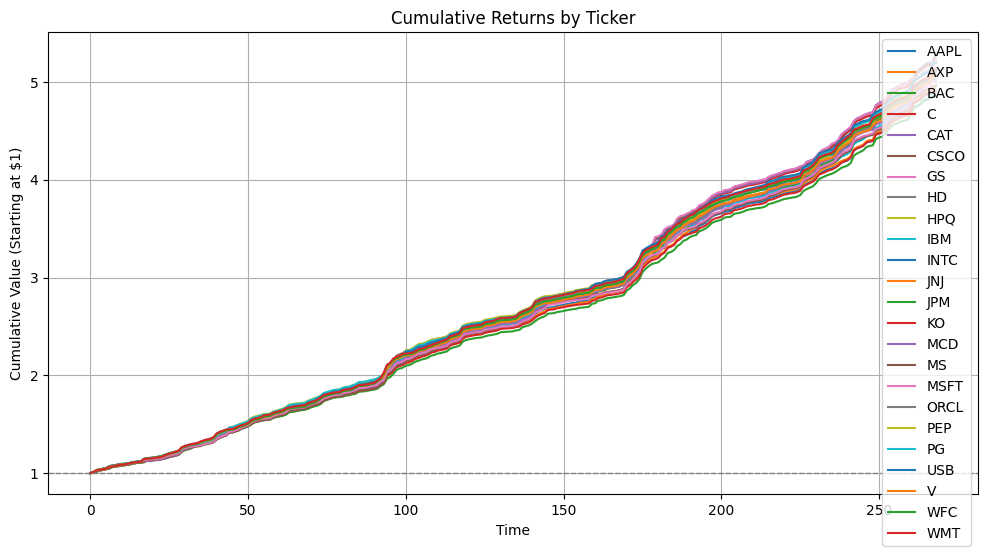

In [65]:
tickers = df_final['Ticker'].unique()  # adjust if your ticker column is named differently
plt.figure(figsize=(12,6))

for t in tickers:
    # mask for this ticker
    mask = df_final['Ticker'].values[-len(y_test):] == t  
    
    pos_t = positions[mask]
    y_t   = y_test[mask]
    strat_ret_t = pos_t * y_t
    
    cum_returns_t = (1 + pd.Series(strat_ret_t)).cumprod()
    
    plt.plot(cum_returns_t.values, label=t)

plt.axhline(1.0, color="gray", linestyle="--", linewidth=1)
plt.title("Cumulative Returns by Ticker")
plt.xlabel("Time")
plt.ylabel("Cumulative Value (Starting at $1)")
plt.legend()
plt.grid(True)
plt.show()

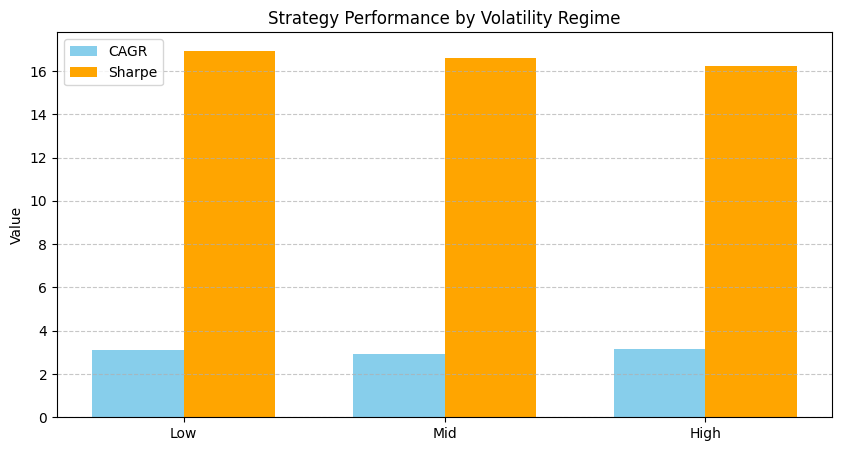

In [66]:
df_regimes = pd.DataFrame(regime_metrics).T
df_regimes = df_regimes[['CAGR', 'Sharpe']]

fig, ax1 = plt.subplots(figsize=(10,5))

bar_width = 0.35
x = range(len(df_regimes))

ax1.bar(x, df_regimes['CAGR'], width=bar_width, color='skyblue', label='CAGR')

ax1.bar([i + bar_width for i in x], df_regimes['Sharpe'], width=bar_width, color='orange', label='Sharpe')

ax1.set_xticks([i + bar_width/2 for i in x])
ax1.set_xticklabels(df_regimes.index.str.capitalize())
ax1.set_ylabel("Value")
ax1.set_title("Strategy Performance by Volatility Regime")
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

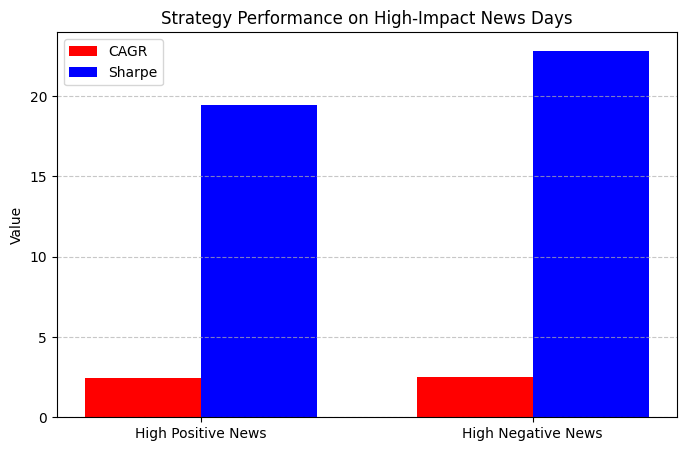

In [67]:
df_news = pd.DataFrame({
    'High Positive News': metrics_high_news,
    'High Negative News': metrics_low_news}).T
df_news_plot = df_news[['CAGR', 'Sharpe']]

fig, ax1 = plt.subplots(figsize=(8,5))
bar_width = 0.35
x = range(len(df_news_plot))

ax1.bar(x, df_news_plot['CAGR'], width=bar_width, color='red', label='CAGR')
ax1.bar([i + bar_width for i in x], df_news_plot['Sharpe'], width=bar_width, color='blue', label='Sharpe')
ax1.set_xticks([i + bar_width/2 for i in x])
ax1.set_xticklabels(df_news_plot.index)
ax1.set_ylabel("Value")
ax1.set_title("Strategy Performance on High-Impact News Days")
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

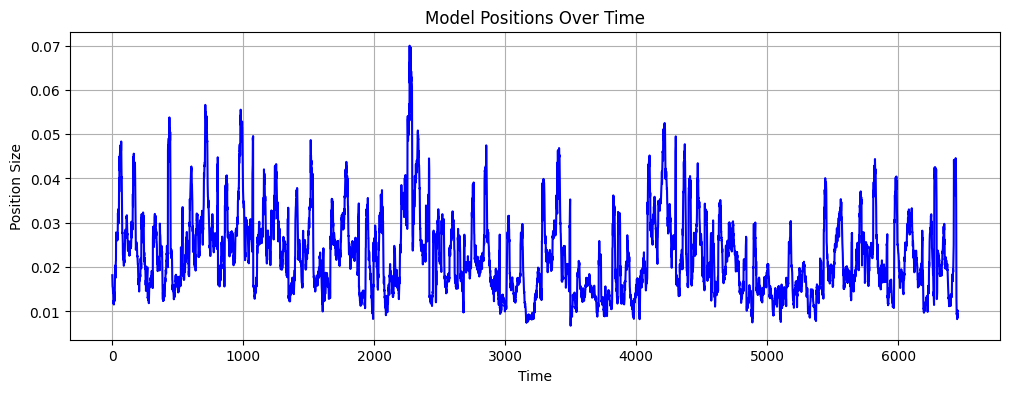

In [68]:
plt.figure(figsize=(12,4))
plt.plot(positions, color='blue')
plt.title("Model Positions Over Time")
plt.xlabel("Time")
plt.ylabel("Position Size")
plt.grid(True)
plt.show()

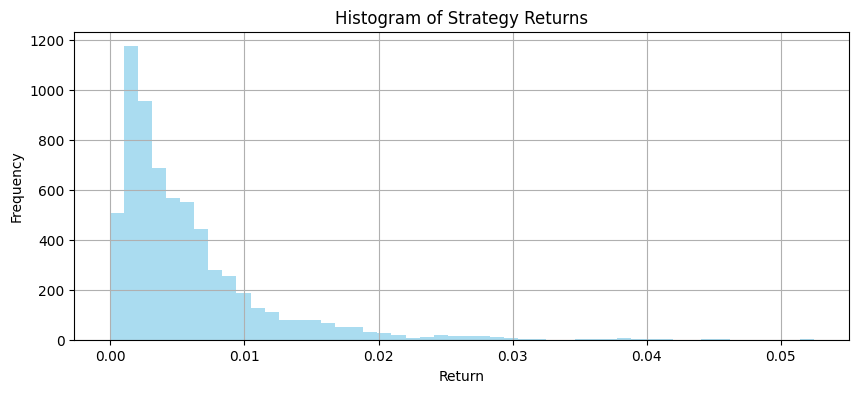

In [69]:
plt.figure(figsize=(10,4))
plt.hist(strategy_returns, bins=50, color='skyblue', alpha=0.7)
plt.title("Histogram of Strategy Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

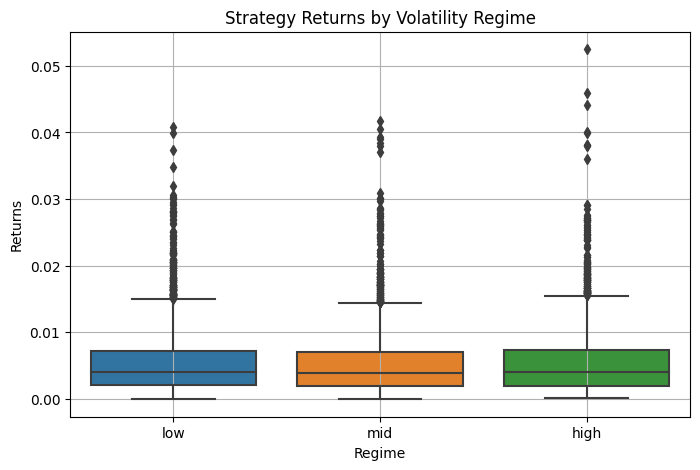

In [70]:
df_plot = pd.DataFrame({
    'Returns': strategy_returns,
    'Regime': regimes
})

plt.figure(figsize=(8,5))
sns.boxplot(x='Regime', y='Returns', data=df_plot, order=['low','mid','high'])
plt.title("Strategy Returns by Volatility Regime")
plt.grid(True)
plt.show()

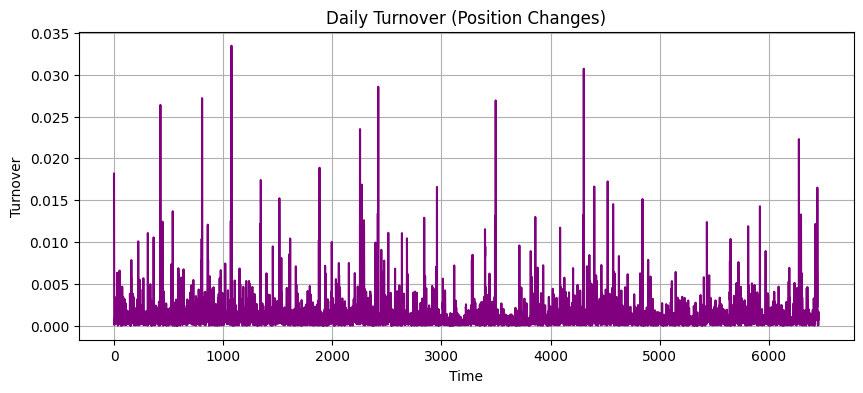

In [71]:
plt.figure(figsize=(10,4))
plt.plot(np.abs(np.diff(np.insert(positions,0,0))), color='purple')
plt.title("Daily Turnover (Position Changes)")
plt.xlabel("Time")
plt.ylabel("Turnover")
plt.grid(True)
plt.show()

## *Model Comparison*

In [74]:
results = {
    "Model": ["XGBoost", "LightGBM", "CatBoost",
              "Simple GRU", "Stacked GRU", "Stacked LSTM",
              "Stacked GRU with Attention", "Stacked LSTM with Attention",
              "Multimodal DL with Attention"],
    "MAE": [xgb_mae, lgb_mae, cat_mae, gru_mae, stackedgru_mae, stackedlstm_mae,
             attentiongru_mae, attentionlstm_mae, multimodal_mae],
    "RMSE": [xgb_rmse, lgb_rmse, cat_rmse, gru_rmse, stackedgru_rmse, stackedlstm_rmse,
             attentiongru_rmse, attentionlstm_rmse, multimodal_rmse],
    "R2": [xgb_r2, lgb_r2, cat_r2, gru_r2, stackedgru_r2, stackedlstm_r2,
             attentiongru_r2, attentionlstm_r2, multimodal_r2],
}

results_df = pd.DataFrame(results)

results_df["MAE_Rank"] = results_df["MAE"].rank(ascending=True)
results_df["RMSE_Rank"] = results_df["RMSE"].rank(ascending=True)
results_df["R2_Rank"] = results_df["R2"].rank(ascending=False)

results_df["Overall_Rank"] = 0.25 * results_df["MAE_Rank"] + 0.25 * results_df["RMSE_Rank"] + 0.5 * results_df["R2_Rank"]
results_df["Overall_Rank"] = results_df["Overall_Rank"].rank(ascending=True)

results_df = results_df.sort_values("Overall_Rank").reset_index(drop=True)

results_df

Model       MAE      RMSE        R2  MAE_Rank  \
0  Multimodal DL with Attention  0.012947  0.021164  0.951267       1.0   
1   Stacked LSTM with Attention  0.015689  0.024518  0.934602       2.0   
2    Stacked GRU with Attention  0.017064  0.025603  0.928686       5.0   
3                       XGBoost  0.016870  0.025791  0.917662       3.0   
4                    Simple GRU  0.017634  0.026959  0.920929       7.0   
5                      LightGBM  0.016893  0.026115  0.915585       4.0   
6                   Stacked GRU  0.017851  0.027130  0.919922       8.0   
7                      CatBoost  0.017132  0.026320  0.914251       6.0   
8                  Stacked LSTM  0.019980  0.028311  0.912801       9.0   

   RMSE_Rank  R2_Rank  Overall_Rank  
0        1.0      1.0           1.0  
1        2.0      2.0           2.0  
2        3.0      3.0           3.0  
3        4.0      6.0           4.0  
4        7.0      4.0           5.0  
5        5.0      7.0           6.0  
6        8.0      5.0           7.0  
7        6.0      8.0           8.0  
8        9.0      9.0           9.0

## *Model Save*

In [77]:
SAVE_DIR = "saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

joblib.dump(xgb, os.path.join(SAVE_DIR, "xgboost_model.pkl"))
joblib.dump(lgb, os.path.join(SAVE_DIR, "lightgbm_model.pkl"))
joblib.dump(cat, os.path.join(SAVE_DIR, "catboost_model.pkl"))

gru.save(os.path.join(SAVE_DIR, "simple_gru.keras"))
stackedgru.save(os.path.join(SAVE_DIR, "stacked_gru.keras"))
stackedlstm.save(os.path.join(SAVE_DIR, "stacked_lstm.keras"))
attentiongru.save(os.path.join(SAVE_DIR, "stacked_gru_attention.keras"))
attentionlstm.save(os.path.join(SAVE_DIR, "stacked_lstm_attention.keras"))
multimodal.save(os.path.join(SAVE_DIR, "multimodal_attention.keras"))

results_df.to_csv(os.path.join(SAVE_DIR, "model_results.csv"), index=False)
results_df.to_excel(os.path.join(SAVE_DIR, "model_results.xlsx"), index=False)

print(f"Models and results are saved inside: {SAVE_DIR}/")

Models and results are saved inside: saved_models/


## *Conclusion*

This project demonstrates a comprehensive approach to volatility prediction across multiple financial tickers by combining traditional machine learning models (XGBoost, LightGBM, CatBoost) with advanced deep learning architectures (Stacked GRU/LSTM, Attention mechanisms and Multimodal Fusion).

The results show that while ensemble tree-based models provide strong baselines, deep learning architectures with attention and multimodal inputs consistently outperform them, capturing both temporal dependencies and contextual signals like sentiment. The Multimodal DL with Attention model emerged as the best performer with the lowest error metrics and the highest R², highlighting the value of integrating structured financial features with unstructured sentiment signals.

This workflow not only establishes a solid benchmark for financial volatility prediction but also provides a scalable framework for future extensions — such as incorporating macroeconomic indicators, news flows, or alternative data sources.